In [ ]:
!pip install faiss-cpu
import numpy as np
import pandas as pd
import faiss
import time
from pathlib import Path
import gc
from scipy.linalg import orth # For creating orthogonal matrices

class FCFC:
    def __init__(self, d, k, niter=25, nredo=1, verbose=True,
                    min_points_per_centroid=1, max_points_per_centroid=1000000000,
                    seed=1234, gpu=False, spherical=False,
                    update_index=True, frozen_centroids=False,
                    lambda_=1.0):
        # d: dimensionality of data
        # k: number of clusters
        self.d_features = d # Renamed for clarity, consistent with other classes
        self.k = k
        self.niter = niter
        self.max_iter = niter # Keep for consistency with existing loop

        # Other parameters (some might not be used by this specific FCFC logic but kept for interface)
        self.nredo = nredo
        self.verbose = verbose
        self.min_points_per_centroid = min_points_per_centroid
        self.max_points_per_centroid = max_points_per_centroid
        self.seed = seed
        self.gpu = gpu # This FCFC implementation is CPU-based
        self.spherical = spherical
        self.update_index = update_index
        self.frozen_centroids = frozen_centroids
        self.lambda_ = lambda_  # Balance parameter for the objective function in get_distance

        # Results storage
        self.centroids = None               # Final cluster centroids (k, d_features)
        self.labels_ = None                 # Final cluster assignments for each point (n_samples,)
        self.runtime_ = None                # Total training time

        self.objective_history_ = None      # History of sum_dis (sum of D(i,j) values)
        self.sse_history_ = None            # History of Sum of Squared Errors per iteration
        self.balance_loss_history_ = None   # History of Balance Loss per iteration

        self.final_objective_ = None        # Final value from objective_history_
        self.final_sse_ = None              # Final Sum of Squared Errors
        self.final_balance_loss_ = None     # Final Balance Loss
        self.final_cluster_sizes_ = None    # Final size of each cluster (k,)

        self.sse_ = 0
        self.balance_loss_ = 0

        # For compatibility, self.obj can point to the primary objective history
        self.obj = None


    def train(self, x, weights=None, init_centroids_arg=None): # Renamed init_centroids to avoid conflict
        np.random.seed(self.seed) # Set seed for reproducibility
        start_time = time.time()

        K = self.k
        if x.shape[1] != self.d_features:
            raise ValueError(f"Input data feature dimension {x.shape[1]} "
                             f"does not match class initialized dimension {self.d_features}")
        n_samples, d_features_data = x.shape # n_samples, d in original code

        # Initialize arrays for storing per-iteration metrics
        # sse_history stores the traditional SSE
        # balance_loss_history stores the balance penalty
        # objective_value_history stores the sum of D(i,j) which is being minimized directly
        sse_history = np.zeros(self.max_iter)
        balance_loss_history = np.zeros(self.max_iter)
        objective_value_history = np.zeros(self.max_iter) # Corresponds to pre_dis

        # Initialize centroids
        # If init_centroids_arg is provided, use it, otherwise use random initialization
        if init_centroids_arg is not None:
            if init_centroids_arg.shape != (K, d_features_data):
                raise ValueError(f"Provided init_centroids shape {init_centroids_arg.shape} "
                                 f"is not ({K}, {d_features_data})")
            current_centroids = np.copy(init_centroids_arg)
        else:
            current_centroids = initial_centroid(x, K, n_samples) # Uses np.random internally

        # size_cluster is 1*K vector, stores size of each cluster for the get_distance objective
        # Initialized to ones to avoid issues if lambda_ > 0 and a cluster is initially empty,
        # though it gets updated immediately in the first iteration.
        # A more common initialization might be n_samples/K or based on initial assignment.
        # Let's base it on an initial quick assignment or n_samples/K to be more robust.
        # For simplicity of matching the provided code, it starts with ones and is quickly updated.
        current_size_cluster = np.ones(K) # Will be updated after first assignment

        current_labels = np.zeros(n_samples, dtype=int) # To store labels for each point

        for i in range(self.max_iter):
            # Assignment step: Calculate D matrix and assign points to clusters
            # D(point, cluster_j) = distance(point, centroid_j)^2 + lambda * size_cluster_j
            D_matrix = get_distance(x, current_centroids, K, n_samples, d_features_data,
                                    current_size_cluster, self.lambda_)

            min_dist_to_centroid_plus_balance = np.min(D_matrix, axis=1) # (n_samples,)
            assigned_labels = np.argmin(D_matrix, axis=1)           # (n_samples,)
            sum_objective_values = np.sum(min_dist_to_centroid_plus_balance)

            current_labels = assigned_labels
            objective_value_history[i] = sum_objective_values

            # Update step: Recalculate centroids and cluster sizes
            # current_size_cluster is based on the new assignments
            current_size_cluster = np.bincount(current_labels, minlength=K)
            current_centroids = get_centroid(x, current_labels, K, n_samples, d_features_data)

            # Calculate SSE and Balance Loss for this iteration (for monitoring)
            iter_sse = 0
            iter_balance_penalty_terms = np.zeros(K)

            for j in range(K):
                cluster_points = x[current_labels == j, :]
                if cluster_points.shape[0] > 0: # If cluster is not empty
                    # SSE part: sum of squared distances to its actual centroid
                    iter_sse += np.sum(np.sum((cluster_points - current_centroids[j, :])**2, axis=1))
                # Balance loss part (using current_size_cluster which is already updated)
                iter_balance_penalty_terms[j] = (current_size_cluster[j] - n_samples / K)**2

            sse_history[i] = iter_sse
            balance_loss_history[i] = np.sum(iter_balance_penalty_terms)

            if self.verbose and (i % 5 == 0 or i == self.max_iter -1) :
                print(f"Iter {i+1}/{self.max_iter}: Objective={objective_value_history[i]:.4f}, "
                      f"SSE={sse_history[i]:.4f}, BalanceLoss={balance_loss_history[i]:.4f}")

        self.runtime_ = time.time() - start_time

        # Store results
        self.centroids = current_centroids
        self.labels_ = current_labels
        self.final_cluster_sizes_ = current_size_cluster

        self.objective_history_ = objective_value_history
        self.sse_history_ = sse_history
        self.balance_loss_history_ = balance_loss_history

        self.final_objective_ = objective_value_history[-1]
        self.final_sse_ = sse_history[-1]
        self.final_balance_loss_ = balance_loss_history[-1]

        self.obj = self.objective_history_ # Storing the history of the optimized objective

        self.sse_ = self.final_sse_
        self.balance_loss_ = self.final_balance_loss_

        if self.verbose:
            print(f"FCFC training completed in {self.runtime_:.4f} seconds.")
            print(f"Final Objective (sum of D(i,j)): {self.final_objective_:.4f}")
            print(f"Final SSE: {self.final_sse_:.4f}")
            print(f"Final Balance Loss: {self.final_balance_loss_:.4f}")
            print(f"Final cluster sizes: {self.final_cluster_sizes_}")

class Lloyd:
    def __init__(self, d, k, niter=25, nredo=1, verbose=True,
                 min_points_per_centroid=1, max_points_per_centroid=1000000000,
                 seed=1234, gpu=False, spherical=False,
                 update_index=True, frozen_centroids=False):
        self.d = d
        self.k = k
        self.niter = niter
        self.nredo = nredo
        self.verbose = verbose
        self.min_points_per_centroid = min_points_per_centroid
        self.max_points_per_centroid = max_points_per_centroid
        self.seed = seed
        self.gpu = gpu
        self.spherical = spherical
        self.update_index = update_index
        self.frozen_centroids = frozen_centroids

        self.centroids = None
        self.obj_history_ = None
        self.labels_ = None

        self.sse_ = None
        self.balance_loss_ = None
        self.runtime_ = None
        self.obj = None

    def compute_centroids_from_data(self, data_points, labels, num_clusters, data_dim):
        centroids = np.zeros((num_clusters, data_dim), dtype=np.float32)
        counts = np.zeros(num_clusters, dtype=int)

        if labels is None:
            if self.verbose:
                print("Warning: Labels are None in compute_centroids_from_data.")
            return centroids

        for i in range(len(data_points)):
            label = labels[i]
            centroids[label] += data_points[i]
            counts[label] += 1

        for j in range(num_clusters):
            if counts[j] > 0:
                centroids[j] /= counts[j]
            else:
                if self.verbose:
                    print(f"Warning: Cluster {j} is empty. Assigning random point.")
                centroids[j] = data_points[np.random.randint(len(data_points))]

        return centroids

    def train(self, x_orig_data, weights=None, init_centroids=None):
        start_time = time.time()
        np.random.seed(self.seed)

        if x_orig_data.shape[1] != self.d:
            raise ValueError(f"Input dimension {x_orig_data.shape[1]} != {self.d}")

        n, dim = x_orig_data.shape
        x = np.ascontiguousarray(x_orig_data, dtype='float32')

        kmeans = faiss.Kmeans(
            d=self.d,
            k=self.k,
            niter=self.niter,
            nredo=self.nredo,
            verbose=self.verbose,
            min_points_per_centroid=self.min_points_per_centroid,
            max_points_per_centroid=self.max_points_per_centroid,
            seed=self.seed,
            gpu=self.gpu,
            spherical=self.spherical,
            update_index=self.update_index,
            frozen_centroids=self.frozen_centroids
        )

        kmeans.train(x, init_centroids=init_centroids)

        _, self.labels_ = kmeans.index.search(x, 1)
        self.labels_ = self.labels_.flatten()

        self.centroids = kmeans.centroids
        self.obj_history_ = kmeans.obj if kmeans.obj is not None and len(kmeans.obj) > 0 else np.zeros(self.niter)
        self.obj = kmeans.obj[-1] if kmeans.obj is not None and len(kmeans.obj) > 0 else None
        self.runtime_ = time.time() - start_time


        # Print every 5th iteration's objective value
        if self.verbose and self.obj_history_ is not None and len(self.obj_history_) > 0:
            print("\n--- Objective Value (every 5 iterations) ---")
            for i, val in enumerate(self.obj_history_):
                if (i + 1) % 5 == 0 or i == len(self.obj_history_) - 1:
                    print(f"  Iter {i+1:2d}: {val:.6f}")

        final_sse = 0
        for i in range(n):
            cluster_idx = self.labels_[i]
            final_sse += np.sum((x_orig_data[i] - self.centroids[cluster_idx]) ** 2)
        self.sse_ = final_sse

        final_balance_loss = 0
        if self.labels_ is not None:
            sizes = np.bincount(self.labels_, minlength=self.k)
            ideal = n / self.k
            final_balance_loss = np.sum((sizes - ideal) ** 2)
        self.balance_loss_ = final_balance_loss

        if self.verbose:
            print(f"Lloyd training finished in {self.runtime_:.4f}s")
            print(f"Final obj: {self.obj}")
            print(f"Cluster sizes: {dict(zip(*np.unique(self.labels_, return_counts=True)))}")
            print(f"SSE: {self.sse_:.4f}")
            print(f"Balance Loss: {self.balance_loss_:.4f}")

class BCLS:
    def __init__(self, d, k, niter=25, nredo=1, verbose=True,
                 min_points_per_centroid=1, max_points_per_centroid=1e9,
                 seed=1234, gpu=False, spherical=False,
                 update_index=True, frozen_centroids=False,
                 lambda_=1.0): # lambda_ from FCFC, but BCLS uses 'lam' internally
        # d: dimensionality of data
        # k: number of clusters
        self.d = d
        self.k = k
        self.niter = niter
        self.nredo = nredo # Not used by BCLS algorithm itself
        self.verbose = verbose
        # The following Faiss-like parameters are not directly used by BCLS's core logic:
        self.min_points_per_centroid = min_points_per_centroid
        self.max_points_per_centroid = max_points_per_centroid
        self.gpu = gpu
        self.spherical = spherical
        self.update_index = update_index
        self.frozen_centroids = frozen_centroids

        self.seed = seed
        self.lambda_bcls = lambda_ # BCLS specific lambda for sum_Y term in objective
                                  # If the lambda_ parameter was meant for this, it's used as 'lam' below.
                                  # If it was for something else, then 'lam' needs its own source.
                                  # Assuming lambda_ is the 'lam' for BCLS objective.

        # Results storage
        self.centroids = None       # Will store centroids in original data space
        self.obj_history_ = None    # Stores Obj2 from the loop
        self.labels_ = None         # Final cluster assignments (0-indexed)
        self.Y_final_ = None        # Final Y matrix (one-hot indicators)

        # Final metrics
        self.sse_ = None
        self.balance_loss_ = None
        self.runtime_ = None

        # For compatibility with previous structure if any part expects 'obj'
        self.obj = None


    def init1(self, n_samples, num_clusters):
        """
        Initializes the Y matrix (n_samples x num_clusters) with one-hot encoding.
        Labels are 1 to num_clusters, then converted to 0-indexed for Python.
        """
        # np.random is affected by self.seed if set before calling train
        labels_1_indexed = np.random.randint(1, num_clusters + 1, size=n_samples)
        F = np.zeros((n_samples, num_clusters))
        F[np.arange(n_samples), labels_1_indexed - 1] = 1
        # F = csr_matrix(F) # Can be sparse if n and k are very large
        return F

    def compute_centroids_from_data(self, data_points, labels, num_clusters, data_dim):
        """
        Calculates centroids from data points and their labels.
        data_points: (n_samples, n_features) - original or centered
        labels: (n_samples,) - 0-indexed
        num_clusters: k
        data_dim: d
        Returns: (num_clusters, data_dim) centroids
        """
        centroids = np.zeros((num_clusters, data_dim), dtype=np.float32)
        counts = np.zeros(num_clusters, dtype=int)

        if labels is None:
            if self.verbose:
                print("Warning: Labels are None in compute_centroids_from_data. Returning zero centroids.")
            return centroids

        for i in range(len(data_points)):
            label = labels[i]
            centroids[label] += data_points[i, :]
            counts[label] += 1

        for j in range(num_clusters):
            if counts[j] > 0:
                centroids[j] /= counts[j]
            else:
                if self.verbose:
                    print(f"Warning: Cluster {j} is empty. Assigning a random data point as its centroid.")
                if len(data_points) > 0:
                    # Seed this random choice for consistency if multiple empty clusters
                    rng_empty_fallback = np.random.RandomState(self.seed + j + 1000) # Offset seed
                    centroids[j] = data_points[rng_empty_fallback.choice(len(data_points)), :]
                # else: centroids[j] remains zeros
        return centroids


    def train(self, x_orig_data, weights=None, init_centroids=None): # x_orig_data is n x dim
        np.random.seed(self.seed) # Ensure reproducibility for operations within train
        start_time = time.time()

        if x_orig_data.shape[1] != self.d:
            raise ValueError(f"Input data feature dimension {x_orig_data.shape[1]} "
                             f"does not match class initialized dimension {self.d}")

        ITER = self.niter
        # BCLS Algorithm Hyperparameters (taken from the provided snippet)
        gamma = 0.00001  # Regularization for W
        lam = self.lambda_bcls # Controls balance term in objective (sum_Y**2)
        mu = 0.01        # ALM parameter

        n, dim = x_orig_data.shape
        c = self.k  # number of clusters

        # Initialize Y
        Y = self.init1(n, c) # Y is n x c

        # Center the data (BCLS works with centered data)
        meanX = np.mean(x_orig_data, axis=0, keepdims=True) # 1 x dim
        x_centered = x_orig_data - meanX # n x dim

        # ALM variables
        Lambda_alm = np.zeros((n, c)) # Lagrange multipliers for Y - Z = 0
        rho = 1.005                # Update factor for mu

        # Precompute part of W update
        # P_inv = x_centered.T @ x_centered + gamma * np.eye(dim)
        # P = np.linalg.inv(P_inv)
        # Using pseudo-inverse for potentially better stability if P_inv is singular/ill-conditioned
        try:
            P = np.linalg.inv(x_centered.T @ x_centered + gamma * np.eye(dim))
        except np.linalg.LinAlgError:
            if self.verbose:
                print("Warning: Standard inverse failed for P. Using pseudo-inverse.")
            P = np.linalg.pinv(x_centered.T @ x_centered + gamma * np.eye(dim))


        obj_history = np.zeros(ITER)
        # Optional: if you want to track SSE/BalanceLoss per iteration (on centered data)
        # sse_iter_history = np.zeros(ITER)
        # balance_loss_iter_history = np.zeros(ITER)


        for iter_idx in range(ITER):
            # --- Solve W and b ---
            # W: dim x c, b: 1 x c
            W = P @ (x_centered.T @ Y)
            b = np.mean(Y, axis=0, keepdims=True) # Or (1/n) * (np.ones((1,n)) @ Y)

            # E = XW + 1b' - Y (Error term for reconstruction using centered X)
            # E_recon: n x c
            E_recon = x_centered @ W + np.ones((n, 1)) @ b - Y

            # --- Solve Z (auxiliary variable for Y) ---
            # Z: n x c
            # Denominator matrix for Z update:
            # Factor = mu**2 + 2 * n * lam * mu  (scalar)
            # Coeff_matrix_inv = (-2 * lam * np.ones((n,n)) + (mu + 2 * n * lam) * np.eye(n)) / Factor
            # Z = Coeff_matrix_inv @ (mu * Y + Lambda_alm)
            # Simpler if Z is updated element-wise or if structure allows.
            # The provided formula for Z seems like a direct solution from a specific formulation.
            # Let's assume the formula is correct as given:
            # Note: (mu**2 + 2 * n * lam * mu) is a scalar.
            # The matrix to invert for Z is effectively ( (mu + 2*n*lam)*I - 2*lam*J ), where J is all-ones matrix.
            # This matrix has a specific inverse (Sherman-Woodbury).
            # For now, using the provided direct calculation:
            mat_for_Z_inv_num = -2 * lam * np.ones((n, n)) + (mu + 2 * n * lam) * np.eye(n)
            mat_for_Z_inv_den = (mu**2 + 2 * n * lam * mu)
            if np.abs(mat_for_Z_inv_den) < 1e-9: # Avoid division by zero
                 if self.verbose: print(f"Warning: Denominator for Z is near zero at iter {iter_idx}")
                 Z = Y # Fallback or handle error
            else:
                 Z = (mat_for_Z_inv_num / mat_for_Z_inv_den) @ (mu * Y + Lambda_alm)


            # --- Solve Y (indicator matrix) ---
            # V: n x c
            V_update = (1 / (2 + mu)) * (2 * x_centered @ W + 2 * np.ones((n, 1)) @ b + mu * Z - Lambda_alm)

            # Update Y by selecting the max element in each row of V_update
            current_labels = np.argmax(V_update, axis=1) # n-element array of 0-indexed labels
            Y = np.zeros((n, c))
            Y[np.arange(n), current_labels] = 1

            # --- Update Lambda (Lagrange multipliers) and mu (penalty parameter) for ALM ---
            Lambda_alm = Lambda_alm + mu * (Y - Z)
            mu = min(mu * rho, 1e5) # Cap mu to avoid very large values

            # --- Calculate Objective Value (for centered data) ---
            sum_Y_elements = np.sum(Y) # Sum of all elements in Y (should be n if Y is strictly one-hot)
            obj_history[iter_idx] = np.trace(E_recon.T @ E_recon) + \
                                    gamma * np.trace(W.T @ W) + \
                                    lam * (sum_Y_elements**2) # Or lam * np.sum( (np.sum(Y, axis=0) - n/c)**2 ) if balance is per cluster size


            # --- In-loop SSE and Balance Loss (on centered data, for monitoring if needed) ---
            # These are calculated based on current Y and centered data.
            # Centroids for centered data: c x dim
            temp_centroids_centered = self.compute_centroids_from_data(x_centered, current_labels, c, dim)

            sse_iter = 0
            for i in range(n):
                cluster_idx = current_labels[i]
                # Using np.sum for squared norm for clarity with dimensions
                sse_iter += np.sum((x_centered[i, :] - temp_centroids_centered[cluster_idx, :])**2)
            # sse_iter_history[iter_idx] = sse_iter

            cluster_sizes_iter = np.sum(Y, axis=0) # n_elements per cluster (1 x c)
            ideal_size_iter = n / c
            balance_loss_iter = np.sum((cluster_sizes_iter - ideal_size_iter)**2)
            # balance_loss_iter_history[iter_idx] = balance_loss_iter

            if self.verbose and (iter_idx % 10 == 0 or iter_idx == ITER -1):
                print(f"Iter {iter_idx+1}/{ITER}, BCLS Obj: {obj_history[iter_idx]:.4f}, "
                      f"Iter SSE (centered): {sse_iter:.2f}, Iter Bal (centered): {balance_loss_iter:.2f}")


        # --- End of iterations ---
        self.runtime_ = time.time() - start_time

        # Store final results
        self.labels_ = np.argmax(Y, axis=1) # Final 0-indexed labels
        self.Y_final_ = Y                   # Final one-hot indicator matrix
        self.obj_history_ = obj_history
        self.obj = obj_history # Compatibility

        # Calculate final centroids in ORIGINAL data space
        # Use x_orig_data and self.labels_
        final_centroids_orig_space = self.compute_centroids_from_data(x_orig_data, self.labels_, c, dim)
        self.centroids = final_centroids_orig_space # Store k x dim centroids

        # Calculate final SSE using ORIGINAL data and ORIGINAL space centroids
        final_sse = 0
        if self.labels_ is not None and self.centroids is not None:
            for i in range(n):
                cluster_idx = self.labels_[i]
                point_orig = x_orig_data[i, :]
                centroid_orig = self.centroids[cluster_idx, :]
                final_sse += np.sum((point_orig - centroid_orig)**2)
        self.sse_ = final_sse

        # Calculate final Balance Loss
        final_balance_loss = 0
        if self.labels_ is not None:
            final_cluster_sizes = np.bincount(self.labels_, minlength=c)
            ideal_size = n / c
            final_balance_loss = np.sum((final_cluster_sizes - ideal_size)**2)
        self.balance_loss_ = final_balance_loss

        if self.verbose:
            print(f"BCLS training completed in {self.runtime_:.4f} seconds.")
            print(f"Final BCLS objective value: {self.obj_history_[-1]:.4f}")
            unique_labels_final, counts_final = np.unique(self.labels_, return_counts=True)
            print(f"Final cluster sizes: {dict(zip(unique_labels_final, counts_final))}")
            if self.centroids is not None:
                print(f"Shape of final centroids (original space): {self.centroids.shape}")
            print(f"Final SSE (original space): {self.sse_:.4f}")
            print(f"Final Balance Loss: {self.balance_loss_:.4f}")


    def compute_centroids(self, x_transposed, F_indicator):
        """
        Computes centroids.
        x_transposed: (dim, n_samples) data matrix (e.g., centered data transposed)
        F_indicator: (n_samples, k) one-hot cluster indicator matrix
        Returns: (k, dim) centroids
        DEPRECATED in favor of compute_centroids_from_data for clarity, but kept if used elsewhere.
        This version is slightly different from compute_centroids_from_data input format.
        """
        num_clusters = F_indicator.shape[1]
        data_dim = x_transposed.shape[0]
        n_samples_check = x_transposed.shape[1]

        if F_indicator.shape[0] != n_samples_check:
            raise ValueError("Mismatch in number of samples between x_transposed and F_indicator.")

        centroids = np.zeros((num_clusters, data_dim), dtype=np.float32)
        counts = np.zeros(num_clusters, dtype=int)

        # Determine labels from F_indicator
        labels = np.argmax(F_indicator, axis=1) # (n_samples,)

        for i in range(n_samples_check):
            cluster_label = labels[i]
            centroids[cluster_label] += x_transposed[:, i] # x_transposed[:, i] is a data point (dim,)
            counts[cluster_label] += 1

        for j in range(num_clusters):
            if counts[j] > 0:
                centroids[j] /= counts[j]
            else:
                if self.verbose:
                    print(f"Warning (compute_centroids): Cluster {j} is empty. Assigning random point.")
                if n_samples_check > 0:
                    rng_empty_fallback = np.random.RandomState(self.seed + j + 2000)
                    centroids[j] = x_transposed[:, rng_empty_fallback.choice(n_samples_check)]
        return centroids

class CDKM_PurePy:
    def __init__(self, X: np.ndarray, c_true: int, debug: int = 0):
        self.X = X.astype(np.float64)  # shape (N, dim)
        self.N, self.dim = self.X.shape
        self.c_true = c_true
        self.debug = debug

        self.Y = []             # replicate list of label vectors
        self.n_iter_ = []       # number of iterations per replicate

        if debug:
            print(f"N = {self.N}, dim = {self.dim}, k = {self.c_true}")

    def opt(self, init_Y: np.ndarray, ITER: int):
        """
        init_Y: (rep, N) array of integer labels
        """
        rep = init_Y.shape[0]
        for rep_i in range(rep):
            y = init_Y[rep_i].copy()
            n_iter = self.opt_once(y, ITER)
            self.Y.append(y)
            self.n_iter_.append(n_iter)

    def opt_once(self, y: np.ndarray, ITER: int) -> int:
        """
        y: shape (N,), initial cluster assignment
        """
        X = self.X
        N, dim, c_true = self.N, self.dim, self.c_true

        xnorm = np.sum(X**2, axis=1)  # shape (N,)
        Sx = np.zeros((dim, c_true))
        n = np.zeros(c_true)

        for i in range(N):
            Sx[:, y[i]] += X[i]
            n[y[i]] += 1

        s = np.sum(Sx**2, axis=0)  # squared norm of each cluster sum vector

        for iter in range(ITER):
            converge = True
            for i in range(N):
                c_old = y[i]
                if n[c_old] == 1:
                    continue

                xi = X[i]
                xiSx = xi @ Sx  # (c,)
                tmp1 = s + 2 * xiSx + xnorm[i]
                tmp1 = tmp1 / (n + 1)
                tmp2 = s / n

                delta = tmp1 - tmp2
                delta[c_old] = s[c_old] / n[c_old] - \
                    (s[c_old] - 2 * xiSx[c_old] + xnorm[i]) / (n[c_old] - 1)

                c_new = np.argmax(delta)

                if c_new != c_old:
                    converge = False
                    y[i] = c_new

                    Sx[:, c_old] -= xi
                    Sx[:, c_new] += xi

                    s[c_old] = np.sum(Sx[:, c_old]**2)
                    s[c_new] = np.sum(Sx[:, c_new]**2)

                    n[c_old] -= 1
                    n[c_new] += 1

                if self.debug and i % 10000 == 0:
                    print(f"i = {i}")

            if self.debug:
                print(f"iter = {iter}")

            if converge:
                break

        # if iter + 1 == ITER:
            # print("not converge")

        return iter + 1

    @property
    def y_pre(self):
        return self.Y


class CDKM:
    def __init__(self, d, k, niter=200, nredo=10, verbose=False, seed=1234, debug=0):
        self.d = d
        self.k = k
        self.niter = niter
        self.nredo = nredo
        self.verbose = verbose
        self.seed = seed
        self.debug = debug
        self.centroids = None
        self.labels_ = None
        self.Y_final_ = None
        self.sse_ = None
        self.balance_loss_ = None
        self.runtime_ = None
        self.n_iter_ = None

    def train(self, x_orig_data, weights=None, init_centroids=None):
        np.random.seed(self.seed)
        start_time = time.time()

        n, dim = x_orig_data.shape
        if dim != self.d:
            raise ValueError(f"Data dimension {dim} does not match expected {self.d}.")

        if init_centroids is None:
            init_Y = initial_Y(x_orig_data, self.k, self.nredo, "random")
        else:
            init_Y = init_centroids

        model = CDKM_PurePy(x_orig_data, self.k, debug=self.debug)
        model.opt(init_Y, ITER=self.niter)
        Y = model.y_pre
        self.n_iter_ = model.n_iter_

        centroids = compute_cluster_centers_cdkm(x_orig_data, Y)
        labels = np.argmax(one_hot(Y[0], self.k), axis=1)

        # Compute SSE
        sse = np.sum((x_orig_data - centroids[labels])**2)

        # Compute balance loss
        counts = np.bincount(labels, minlength=self.k)
        ideal_size = n / self.k
        balance_loss = np.sum((counts - ideal_size)**2)

        self.Y_final_ = one_hot(Y[0], self.k)
        self.centroids = centroids
        self.labels_ = labels
        self.sse_ = sse
        self.balance_loss_ = balance_loss
        self.runtime_ = time.time() - start_time

        if self.verbose:
            print(f"CDKM finished in {self.runtime_:.4f}s; "
                  f"SSE = {self.sse_:.4f}; "
                  f"Balance Loss = {self.balance_loss_:.4f}; "
                  f"Iterations = {self.n_iter_}")

class BKNC:
    def __init__(self, d, k, niter=25, nredo=1, verbose=False,
                    min_points_per_centroid=1, max_points_per_centroid=1e9,
                    seed=1234, gpu=False, spherical=False,
                    update_index=True, frozen_centroids=False,
                    lambda_=1.0):
        # d: dimensionality of data (n_features)
        # k: number of clusters (c in BKNC)
        self.d_features = d
        self.k = k  # c in BKNC
        self.niter = niter # Niter in BKNC
        self.lambda_ = lambda_ # lambda in BKNC
        self.seed = seed
        self.verbose = verbose

        # Other Faiss Kmeans parameters - not directly used by BKNC logic
        self.nredo = nredo
        self.min_points_per_centroid = min_points_per_centroid
        self.max_points_per_centroid = max_points_per_centroid
        self.gpu = gpu # BKNC as implemented here is CPU-only
        self.spherical = spherical
        self.update_index = update_index
        self.frozen_centroids = frozen_centroids

        # BKNC specific results
        self.F_ = None          # The F matrix from BKNC (n_samples x k)
        self.R_ = None          # The R matrix (k x k)
        self.Y_ = None          # The Y matrix (one-hot labels, n_samples x k)
        self.labels_ = None     # Final cluster assignments (idx, shape: n_samples)
        self.obj_history_ = []  # History of the objective function trace(F'X_m'X_mF)
        self.final_obj_ = None
        self.runtime_ = 0

        # For compatibility with original FCFC structure
        self.centroids = None # Will be populated with cluster means
        self.obj = None # Can store obj_history_ here

        # Final metrics as requested
        self.sse_ = None
        self.balance_loss_ = None


    def _initialize_Y_bknc(self, n_samples, c):
        """
        Equivalent to MATLAB's init function for Y.
        Creates an n_samples x c one-hot encoded matrix from random labels.
        """
        # labels are 0 to c-1
        # This internal seeding should be fine as long as the main train method sets the overall seed.
        # If this method were called multiple times independently *within* one train call,
        # and expected different Ys, then it would need a different seeding strategy.
        # For now, it's called once per train.
        labels = np.random.randint(0, c, size=n_samples)
        Y = np.zeros((n_samples, c), dtype=int)
        Y[np.arange(n_samples), labels] = 1
        return Y

    def _calculate_cluster_centroids(self, data, labels, num_clusters, data_dim):
        """
        Calculates the mean of points in each cluster.
        data: (n_samples, n_features)
        labels: (n_samples,)
        num_clusters: k
        data_dim: d_features
        """
        centroids = np.zeros((num_clusters, data_dim))
        if labels is None: # Should not happen if called after labels are set
             if self.verbose:
                print("Warning: Labels are None in _calculate_cluster_centroids. Returning zero centroids.")
             return centroids

        for i in range(num_clusters):
            cluster_points = data[labels == i]
            if len(cluster_points) > 0:
                centroids[i] = np.mean(cluster_points, axis=0)
            else:
                if self.verbose:
                    print(f"Warning: Cluster {i} is empty during centroid calculation. Assigning a random data point as its centroid.")
                if len(data) > 0:
                    # Use a random number generator seeded by self.seed for consistent fallback
                    rng_fallback = np.random.RandomState(self.seed + i) # Add i for variety if multiple fallbacks
                    centroids[i] = data[rng_fallback.choice(len(data))]
                else: # No data points at all (edge case)
                    centroids[i] = np.zeros(data_dim)
        return centroids

    def train(self, x, weights=None, init_centroids=None):
        """
        Implements the BKNC algorithm.
        x: data matrix (n_samples, n_features)
        weights: Not used by BKNC.
        init_centroids: Not used by BKNC.
        """
        np.random.seed(self.seed) # Set seed for reproducibility for the entire train method
        start_time = time.time()

        if x.shape[1] != self.d_features:
            raise ValueError(f"Input data feature dimension {x.shape[1]} "
                             f"does not match class initialized dimension {self.d_features}")

        X_m = x.T  # (n_features, n_samples) - X_m is the MATLAB-like X
        n_features_internal, n_samples = X_m.shape # n_features_internal is self.d_features
        c = self.k # Number of clusters

        # Initialize Y (n_samples, c)
        # _initialize_Y_bknc uses np.random, which is now seeded by self.seed
        Y = self._initialize_Y_bknc(n_samples, c)

        # Initialize R (c, c) as a random orthogonal matrix
        # np.random.rand is also affected by the global seed set above
        R = orth(np.random.rand(c, c))

        obj_log = np.zeros(self.niter)

        # F_loop initialization is also seeded
        for iter_num in range(self.niter):
            F_loop = orth(np.random.rand(n_samples, c))
            G = Y @ R.T

            for _ in range(10):
                TempM_F = X_m @ F_loop
                M_calc_F = 2 * X_m.T @ TempM_F + self.lambda_ * G
                U_f, _, Vh_f = np.linalg.svd(M_calc_F, full_matrices=False)
                F_loop = U_f @ Vh_f
            F_current = F_loop

            N_calc_R = F_current.T @ Y
            U_r, _, Vh_r = np.linalg.svd(N_calc_R, full_matrices=False)
            R = U_r @ Vh_r

            P_calc_Y = R.T @ F_current.T
            idx = np.argmax(P_calc_Y, axis=0)
            Y = np.zeros((n_samples, c), dtype=int)
            Y[np.arange(n_samples), idx] = 1

            TempF_obj = X_m @ F_current
            obj_log[iter_num] = np.trace(TempF_obj.T @ TempF_obj)

            if self.verbose and (iter_num % 5 == 0 or iter_num == self.niter -1):
                print(f"Iter {iter_num+1}/{self.niter}, BKNC Obj: {obj_log[iter_num]:.4f}")

        self.runtime_ = time.time()

        # Store BKNC results
        self.F_ = F_current
        self.R_ = R
        self.Y_ = Y # This is the one-hot version of labels from the last iteration
        self.labels_ = idx # finalInd in MATLAB (0-indexed labels)
        self.obj_history_ = obj_log
        self.final_obj_ = obj_log[-1]
        self.obj = self.obj_history_ # Compatibility

        # --- Calculate final centroids, SSE, and Balance Loss ---
        # self.centroids are calculated based on original data `x` and final `self.labels_`
        self.centroids = self._calculate_cluster_centroids(x, self.labels_, self.k, self.d_features)

        # Calculate SSE
        current_sse = 0
        if self.labels_ is not None and self.centroids is not None:
            for i in range(n_samples):
                cluster_idx = self.labels_[i]
                point = x[i, :]
                centroid_val = self.centroids[cluster_idx, :]
                current_sse += np.sum((point - centroid_val)**2) # Squared Euclidean distance
        self.sse_ = current_sse

        # Calculate Balance Loss
        current_balance_loss = 0
        if self.labels_ is not None:
            cluster_sizes = np.bincount(self.labels_, minlength=self.k)
            ideal_size = n_samples / self.k
            current_balance_loss = np.sum((cluster_sizes - ideal_size)**2)
        self.balance_loss_ = current_balance_loss

        # Final runtime calculation
        self.runtime_ = time.time() - start_time # Corrected runtime calculation

        if self.verbose:
            print(f"BKNC training completed in {self.runtime_:.4f} seconds.")
            print(f"Final BKNC objective (trace): {self.final_obj_:.4f}")
            unique_labels_final, counts_final = np.unique(self.labels_, return_counts=True)
            print(f"Final cluster sizes: {dict(zip(unique_labels_final, counts_final))}")
            if self.centroids is not None:
                print(f"Shape of calculated centroids: {self.centroids.shape}")
            print(f"Final SSE: {self.sse_:.4f}")
            print(f"Final Balance Loss: {self.balance_loss_:.4f}")

class MyKMeans:
    def __init__(self, d, k, niter=25, nredo=1, verbose=False,
                    min_points_per_centroid=1, max_points_per_centroid=1e9,
                    seed=1234, gpu=False, spherical=False,
                    update_index=True, frozen_centroids=False,
                    lambda_=1.0):
        # d: dimensionality of data (n_features)
        # k: number of clusters (c in BKNC)
        self.d_features = d
        self.k = k  # c in BKNC
        self.niter = niter # Niter in BKNC
        self.lambda_ = lambda_ # lambda in BKNC
        self.lambda_reformed = (1-lambda_)/lambda_
        self.seed = seed
        self.verbose = verbose

        # Other Faiss Kmeans parameters - not directly used by BKNC logic
        self.nredo = nredo
        self.min_points_per_centroid = min_points_per_centroid
        self.max_points_per_centroid = max_points_per_centroid
        self.gpu = gpu # BKNC as implemented here is CPU-only
        self.spherical = spherical
        self.update_index = update_index
        self.frozen_centroids = frozen_centroids

        # BKNC specific results
        self.F_ = None          # The F matrix from BKNC (n_samples x k)
        self.R_ = None          # The R matrix (k x k)
        self.Y_ = None          # The Y matrix (one-hot labels, n_samples x k)
        self.labels_ = None     # Final cluster assignments (idx, shape: n_samples)
        self.obj_history_ = []  # History of the objective function trace(F'X_m'X_mF)
        self.final_obj_ = None
        self.runtime_ = 0

        # For compatibility with original FCFC structure
        self.centroids = None # Will be populated with cluster means
        self.obj = None # Can store obj_history_ here

        # Final metrics as requested
        self.sse_ = None
        self.balance_loss_ = None


    def _initialize_Y_bknc(self, n_samples, c):
        """
        Equivalent to MATLAB's init function for Y.
        Creates an n_samples x c one-hot encoded matrix from random labels.
        """
        # labels are 0 to c-1
        # This internal seeding should be fine as long as the main train method sets the overall seed.
        # If this method were called multiple times independently *within* one train call,
        # and expected different Ys, then it would need a different seeding strategy.
        # For now, it's called once per train.
        labels = np.random.randint(0, c, size=n_samples)
        Y = np.zeros((n_samples, c), dtype=int)
        Y[np.arange(n_samples), labels] = 1
        return Y

    def _calculate_cluster_centroids(self, data, labels, num_clusters, data_dim):
        """
        Calculates the mean of points in each cluster.
        data: (n_samples, n_features)
        labels: (n_samples,)
        num_clusters: k
        data_dim: d_features
        """
        centroids = np.zeros((num_clusters, data_dim))
        if labels is None: # Should not happen if called after labels are set
             if self.verbose:
                print("Warning: Labels are None in _calculate_cluster_centroids. Returning zero centroids.")
             return centroids

        for i in range(num_clusters):
            cluster_points = data[labels == i]
            if len(cluster_points) > 0:
                centroids[i] = np.mean(cluster_points, axis=0)
            else:
                if self.verbose:
                    print(f"Warning: Cluster {i} is empty during centroid calculation. Assigning a random data point as its centroid.")
                if len(data) > 0:
                    # Use a random number generator seeded by self.seed for consistent fallback
                    rng_fallback = np.random.RandomState(self.seed + i) # Add i for variety if multiple fallbacks
                    centroids[i] = data[rng_fallback.choice(len(data))]
                else: # No data points at all (edge case)
                    centroids[i] = np.zeros(data_dim)
        return centroids

    def train(self, x, weights=None, init_centroids=None):
        """
        Implements the BKNC algorithm.
        x: data matrix (n_samples, n_features)
        weights: Not used by BKNC.
        init_centroids: Not used by BKNC.
        """
        np.random.seed(self.seed) # Set seed for reproducibility for the entire train method
        start_time = time.time()

        if x.shape[1] != self.d_features:
            raise ValueError(f"Input data feature dimension {x.shape[1]} "
                             f"does not match class initialized dimension {self.d_features}")

        X_m = x.T  # (n_features, n_samples) - X_m is the MATLAB-like X
        n_features_internal, n_samples = X_m.shape # n_features_internal is self.d_features
        c = self.k # Number of clusters

        # Initialize Y (n_samples, c)
        # _initialize_Y_bknc uses np.random, which is now seeded by self.seed
        Y = self._initialize_Y_bknc(n_samples, c)

        # Initialize R (c, c) as a random orthogonal matrix
        # np.random.rand is also affected by the global seed set above
        R = orth(np.random.rand(c, c))

        obj_log = np.zeros(self.niter)

        # F_loop initialization is also seeded
        for iter_num in range(self.niter):
            F_loop = orth(np.random.rand(n_samples, c))
            G = Y @ R.T

            for _ in range(10):
                TempM_F = X_m @ F_loop
                M_calc_F = 2 * X_m.T @ TempM_F + self.lambda_reformed * G
                U_f, _, Vh_f = np.linalg.svd(M_calc_F, full_matrices=False)
                F_loop = U_f @ Vh_f
            F_current = F_loop

            N_calc_R = F_current.T @ Y
            U_r, _, Vh_r = np.linalg.svd(N_calc_R, full_matrices=False)
            R = U_r @ Vh_r

            P_calc_Y = R.T @ F_current.T
            idx = np.argmax(P_calc_Y, axis=0)
            Y = np.zeros((n_samples, c), dtype=int)
            Y[np.arange(n_samples), idx] = 1

            TempF_obj = X_m @ F_current
            obj_log[iter_num] = np.trace(TempF_obj.T @ TempF_obj)

            if self.verbose and (iter_num % 5 == 0 or iter_num == self.niter -1):
                print(f"Iter {iter_num+1}/{self.niter}, BKNC Obj: {obj_log[iter_num]:.4f}")

        self.runtime_ = time.time()

        # Store BKNC results
        self.F_ = F_current
        self.R_ = R
        self.Y_ = Y # This is the one-hot version of labels from the last iteration
        self.labels_ = idx # finalInd in MATLAB (0-indexed labels)
        self.obj_history_ = obj_log
        self.final_obj_ = obj_log[-1]
        self.obj = self.obj_history_ # Compatibility

        # --- Calculate final centroids, SSE, and Balance Loss ---
        # self.centroids are calculated based on original data `x` and final `self.labels_`
        self.centroids = self._calculate_cluster_centroids(x, self.labels_, self.k, self.d_features)

        # Calculate SSE
        current_sse = 0
        if self.labels_ is not None and self.centroids is not None:
            for i in range(n_samples):
                cluster_idx = self.labels_[i]
                point = x[i, :]
                centroid_val = self.centroids[cluster_idx, :]
                current_sse += np.sum((point - centroid_val)**2) # Squared Euclidean distance
        self.sse_ = current_sse

        # Calculate Balance Loss
        current_balance_loss = 0
        if self.labels_ is not None:
            cluster_sizes = np.bincount(self.labels_, minlength=self.k)
            ideal_size = n_samples / self.k
            current_balance_loss = np.sum((cluster_sizes - ideal_size)**2)
        self.balance_loss_ = current_balance_loss

        # Final runtime calculation
        self.runtime_ = time.time() - start_time # Corrected runtime calculation

        if self.verbose:
            print(f"BKNC training completed in {self.runtime_:.4f} seconds.")
            print(f"Final BKNC objective (trace): {self.final_obj_:.4f}")
            unique_labels_final, counts_final = np.unique(self.labels_, return_counts=True)
            print(f"Final cluster sizes: {dict(zip(unique_labels_final, counts_final))}")
            if self.centroids is not None:
                print(f"Shape of calculated centroids: {self.centroids.shape}")
            print(f"Final SSE: {self.sse_:.4f}")
            print(f"Final Balance Loss: {self.balance_loss_:.4f}")

# Helper functions (moved outside the class, or could be static methods)
def initial_Y(X, c, rep, way="random"):
        N = X.shape[0]
        Y = np.zeros((rep, N), dtype=np.int32)

        if way == "random":
            for rep_i in range(rep):
                Y[rep_i] = np.random.randint(0, c, N)

        elif way == "k-means++":
            for rep_i in range(rep):
                Y[rep_i] = KMeans(n_clusters=c, init="k-means++", n_init=1, max_iter=1).fit(X).labels_

        else:
            assert 2 == 1

        return Y
def one_hot(y: np.ndarray, k: int):
    n = len(y)
    Y = np.zeros((n, k), dtype=np.float32)
    Y[np.arange(n), y] = 1.0
    return Y
def compute_cluster_centers_cdkm(X, Y):
    """
    X: (n, d)
    Y: list of cluster label arrays, each of shape (n,)
    """
    y = Y[0]  # shape (n,)
    n, k = X.shape[0], np.max(y) + 1
    Y0 = np.zeros((n, k), dtype=np.float64)
    Y0[np.arange(n), y] = 1.0  # one-hot

    weights = np.sum(Y0, axis=0)  # (k,)
    weights[weights == 0] = 1e-10

    centers = (Y0.T @ X) / weights[:, None]
    return centers



def get_centroid(data, label, K, n, d_features):
    """
    Update centroids after the assignment phase.
    data: (n, d_features)
    label: (n,)
    K: number of clusters
    n: number of samples
    d_features: number of features
    """
    centroids = np.zeros((K, d_features))
    for k_idx in range(K):
        members = (label == k_idx)
        if np.any(members):
            # Np.sum on boolean array members gives count of True values
            centroids[k_idx, :] = np.sum(data[members, :], axis=0) / np.sum(members)
        else:
            # Handle empty cluster: assign a random point from data
            # This random choice is now affected by the seed set in train()
            if n > 0 : # Ensure data is not empty
                 centroids[k_idx, :] = data[np.random.choice(n), :]
            # else: centroid remains zeros if data is empty (edge case)
    return centroids


def get_distance(data, centroids, K, n, d_features, size_cluster, lambda_param):
    """
    Objective function term for assignment:
    D(i,j) = distance(i-th data point, j-th centroid)^2 + lambda_param * size_of_jth_cluster
    data: (n, d_features)
    centroids: (K, d_features)
    size_cluster: (K,) - current size of each cluster
    lambda_param: balance weight
    Returns: D_matrix (n, K)
    """
    D_matrix = np.zeros((n, K))
    for k_idx in range(K):
        # Squared Euclidean distance
        dist_sq = np.sum((data - centroids[k_idx, :])**2, axis=1)
        D_matrix[:, k_idx] = dist_sq + lambda_param * size_cluster[k_idx]
    return D_matrix


def initial_centroid(x_data, K, n_samples):
    """
    Initialize centroids randomly by choosing K unique points from the data.
    x_data: (n_samples, d_features)
    K: number of clusters
    n_samples: number of samples
    """
    if K > n_samples:
        raise ValueError("K (number of clusters) cannot be greater than n_samples.")
    # This random choice is now affected by the seed set in train()
    indices = np.random.choice(n_samples, K, replace=False)
    return x_data[indices, :]

# 优化后的数据加载函数
def load_data_chunked(path, dtype='float32', chunksize=1000):
    """分块加载大数据集避免内存溢出"""
    chunks = []
    for chunk in pd.read_csv(path, header=None, chunksize=chunksize):
        chunks.append(chunk.astype(dtype))
    return np.concatenate(chunks, axis=0)

def run_experiment(model_class, model_name, dataset_path, dimensions, n_clusters, n_runs=1):
    """运行实验并返回时间记录"""
    try:
        # 读取数据
        # X_data = pd.read_csv(dataset_path, header=None).values.astype(np.float32)
        X_data = load_data_chunked(dataset_path)

        # 准备结果存储
        results = []

        for run in range(n_runs):
            # 初始化模型 - 根据模型类型设置不同参数
            if model_name == "FCFC":
                model = model_class(d=dimensions, k=n_clusters, niter=10, lambda_=0.1, seed=1234+run, verbose=False)
            elif model_name == "BCLS":
                model = model_class(d=dimensions, k=n_clusters, niter=10, lambda_=0.1, seed=1234+run, verbose=False)
            elif model_name == "Lloyd":
                model = model_class(d=dimensions, k=n_clusters, niter=10, seed=1234+run, verbose=False)
            elif model_name == "CDKM":
                model = model_class(d=dimensions, k=n_clusters, niter=10, seed=1234+run, verbose=False)
            elif model_name == "BKNC":
                model = model_class(d=dimensions, k=n_clusters, niter=10, lambda_=0.1, seed=1234+run, verbose=False)
            else:  # MyKmeans
                model = model_class(d=dimensions, k=n_clusters, niter=10, lambda_=0.1, seed=1234+run, verbose=False)

            model.train(X_data) if hasattr(model, 'train') else model.fit(X_data)
            # runtime = model.runtime_
            # print(f"runtime: {runtime}")
            # print(f"balance loss: {model.balance_loss_}")
            print(f"sse: {model.sse_}")

        # return model.balance_loss_
        return model.sse_

    finally:
        # 强制内存清理
        if 'X_data' in locals(): del X_data
        if 'model' in locals(): del model
        gc.collect()

if __name__ == '__main__':
    # 定义要测试的模型和数据集
    models = [
        (Lloyd, "Lloyd"),
        (CDKM, "CDKM"),
        (BCLS, "BCLS"),
        (FCFC, "FCFC"),
        (BKNC, "BKNC"),
        (MyKMeans, "MyKMeans")
    ]

    # 定义数据集路径和对应的维度
    datasets = [
        ("/content/sample_data/Huatuo_1024d_10k.csv", 1024),
        ("/content/sample_data/LiveChat_1024d_10k.csv", 1024),
        # ("/content/sample_data/bigann_128d_10k.csv", 128),
        ("/content/sample_data/deep_96d_10k.csv", 96),
        ("/content/sample_data/glove_300d_10k.csv", 300),
        ("/content/sample_data/sift_128d_10k.csv", 128)
    ]
    k_values = [5, 10, 20, 50, 100]

    # 收集所有结果
    # all_results = []

    # 创建结果DataFrame
    results = pd.DataFrame()
    results.index.name = "Row"

    count = 1

    for k in k_values:
        print(f"\n=== Running experiments for k={k} ===")

        # 为当前k值创建临时DataFrame
        temp_df = pd.DataFrame(index=range(1, len(datasets)+1))

        for model_class, model_name in models:
            col_name = count
            count = count + 1
            temp_df[col_name] = np.nan  # 初始化列

            # 在每个数据集上运行
            for row, (dataset_path, dim) in enumerate(datasets, start=1):
                print(f"Running {model_name} on {Path(dataset_path).stem} (d={dim}, k={k})...")
                balance_loss = run_experiment(model_class, model_name, dataset_path, dim, k)
                temp_df.at[row, col_name] = balance_loss

        # 将当前k值的结果添加到主DataFrame，并添加1列空列
        results = pd.concat([results, temp_df, pd.DataFrame(columns=[count])], axis=1)
        count = count + 1

    # 删除最后一列空白列（如果全部为空）
    if len(results.columns) > 0:
        last_col = results.columns[-1]
        if results[last_col].isna().all():  # 检查最后一列是否全部为空
            results = results.iloc[:, :-1]  # 删除最后一列
            print(f"已删除空白列: {last_col}")
        else:
            print("最后一列包含数据，未删除")

    # results.to_csv('/content/sample_data/balance_loss_results.csv', index=False)
    # print("\nExperiment results saved to 'balance_loss_results.csv'")
    results.to_csv('/content/sample_data/sse_results.csv', index=False)
    print("\nExperiment results saved to 'sse_results.csv'")


=== Running experiments for k=5 ===
Running Lloyd on Huatuo-1024d_10k (d=1024, k=5)...
sse: 2667.185302734375
Running Lloyd on LiveChat-1024d_10k (d=1024, k=5)...
sse: 1928.67529296875
Running Lloyd on deep_96d_10k (d=96, k=5)...
sse: 8132.88037109375
Running Lloyd on glove_300d_10k (d=300, k=5)...
sse: 364035.09375
Running Lloyd on sift_128d_10k (d=128, k=5)...
sse: 654041600.0
Running CDKM on Huatuo-1024d_10k (d=1024, k=5)...
sse: 2649.1871792725756
Running CDKM on LiveChat-1024d_10k (d=1024, k=5)...
sse: 1929.4858036063054
Running CDKM on deep_96d_10k (d=96, k=5)...
sse: 8110.630506438794
Running CDKM on glove_300d_10k (d=300, k=5)...
sse: 363822.5742331777
Running CDKM on sift_128d_10k (d=128, k=5)...
sse: 649673187.425181
Running BCLS on Huatuo-1024d_10k (d=1024, k=5)...
sse: 3123.354248046875
Running BCLS on LiveChat-1024d_10k (d=1024, k=5)...
sse: 2033.1434326171875
Running BCLS on deep_96d_10k (d=96, k=5)...
sse: 8839.453125
Running BCLS on glove_300d_10k (d=300, k=5)...
sse: 

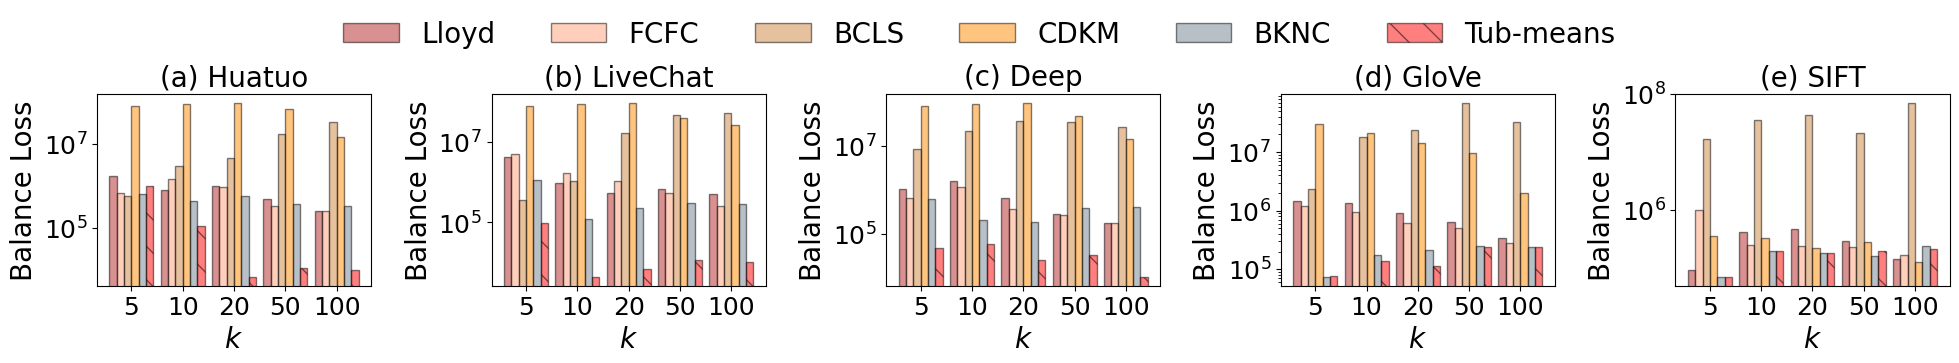

In [ ]:
# 画balance loss
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.ticker as ticker

# 读取数据
balance_loss = pd.read_csv('/content/sample_data/balance_loss_results.csv')
balance_loss = balance_loss.to_numpy()

# 设置参数
methods = ["Lloyd", "FCFC", "BCLS", "CDKM", "BKNC", "Tub-means"]  # 4种方法
colors = [
    '#B22222',  # firebrick
    '#FFA07A',  # lightsalmon
    '#CD853F',  # peru
    '#FF8C00',  # dark orange
    '#708090',  # slate gray
    '#FF0000'  # red
]
hatches = [None, None, None, None, None, '\\']  # 4种填充样式
k_values = ['5', '10', '20', '50', '100']  # k值标签
# k_values = [
#     r"$\frac{n}{2000}$",
#     r"$\frac{n}{1000}$",
#     r"$\frac{n}{500}$",
#     r"$\frac{n}{200}$",
#     r"$\frac{n}{100}$"
# ]
titles = ["(a) Huatuo", "(b) LiveChat", "(c) Deep", "(d) GloVe", "(e) SIFT"]  # 子图标题

# 图形设置
fs = 20  # 字体大小
fig, axs = plt.subplots(1, 5, figsize=(20, 3.4))
axs = axs.flatten()

# 每个k值组包含4个方法柱+1个空列
n_methods = len(methods)
n_k = len(k_values)
group_size = n_methods + 1  # 每组5列(4方法+1空)
total_bars = n_k * group_size - 1  # 总共24列

for i, ax in enumerate(axs[:5]):  # 处理5个子图
    # 绘制柱状图
    bar_pos = 0  # 当前位置
    for k_idx in range(n_k):
        # 绘制4个方法的柱状图
        for method_idx in range(n_methods):
            ax.bar(bar_pos, balance_loss[i, bar_pos], 1.0,
                   color=colors[method_idx], hatch=hatches[method_idx], alpha=0.5,
                   edgecolor='black', label=methods[method_idx] if i==0 and k_idx==0 else "")
            bar_pos += 1
        # 跳过空列(最后一组k值后不需要空列)
        if k_idx < n_k - 1:
            bar_pos += 1

    # 设置x轴刻度(位于每组中间)
    tick_positions = [k*(group_size) + (n_methods-1)/2 for k in range(n_k)]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(k_values, fontsize=fs*0.9)

    # 其他设置
    ax.set_ylabel('Balance Loss', fontsize=fs)
    ax.set_xlabel("$k$", fontsize=fs)
    ax.set_yscale("log")
    ax.tick_params(axis='y', labelsize=fs*0.9)
    ax.set_title(titles[i], fontsize=fs)

# 添加图例
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',
           fontsize=fs, bbox_to_anchor=(0.5, 1.14),
           ncol=n_methods, fancybox=False, shadow=False, frameon=False)

# 调整布局
plt.tight_layout()
plt.subplots_adjust(top=0.85, wspace=0.44, hspace=0.5)
mpl.rcParams.update({'font.size': fs})

plt.savefig("balance_loss_results.pdf", format="pdf", bbox_inches="tight")
plt.show()

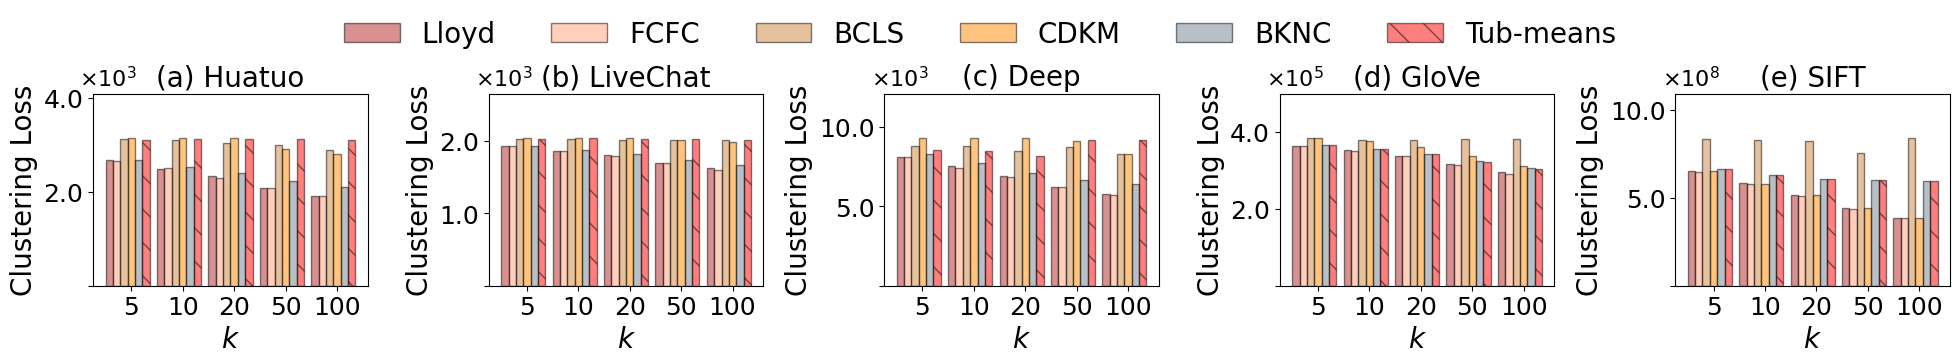

In [ ]:
# 画sse/clustering loss
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import math

# ------------------------
# 1. 读取 CSV
# ------------------------
matrix = pd.read_csv('/content/sample_data/sse_results.csv').to_numpy()

# ------------------------
# 2. 样式
# ------------------------
methods = ["Lloyd", "FCFC", "BCLS", "CDKM", "BKNC", "Tub-means"]  # 4种方法
colors = [
    '#B22222',  # firebrick
    '#FFA07A',  # lightsalmon
    '#CD853F',  # peru
    '#FF8C00',  # dark orange
    '#708090',  # slate gray
    '#FF0000'  # red
]
hatches = [None, None, None, None, None, '\\']  # 4种填充样式
k_values = ['5', '10', '20', '50', '100']  # k值标签
# k_values = [
#     r"$\frac{n}{2000}$",
#     r"$\frac{n}{1000}$",
#     r"$\frac{n}{500}$",
#     r"$\frac{n}{200}$",
#     r"$\frac{n}{100}$"
# ]
titles = ["(a) Huatuo", "(b) LiveChat", "(c) Deep", "(d) GloVe", "(e) SIFT"]

n_methods = 6
n_kvalues = 5
total_bars = n_kvalues * (n_methods + 1) - 1

fs = 20
fig, axs = plt.subplots(1, 5, figsize=(20, 3.4))
axs = axs.flatten()

# ------------------------
# 3. 画柱状图（每个子图自动提取base）
# ------------------------
for i, ax in enumerate(axs):
    if i < 5:
        x_pos = np.arange(total_bars)

        # 过滤掉 NaN 求最大值
        y_data = matrix[i]
        max_val = np.nanmax(y_data)

        # 计算缩放基数和Y轴上限（增加20%顶部空间）
        exponent = int(math.floor(math.log10(max_val)))
        base = 10 ** exponent
        y_scaled = y_data / base
        y_max = np.nanmax(y_scaled) * 1.3  # 增加20%空间

        bars = ax.bar(x_pos, y_scaled, width=1.0, align='center', alpha=0.5)

        # 设置Y轴范围，确保顶部有20%空白
        ax.set_ylim(0, y_max)

        bar_idx = 0
        for j in range(total_bars):
            if j % (n_methods + 1) < n_methods:
                bars[j].set_color(colors[bar_idx % n_methods])
                bars[j].set_hatch(hatches[bar_idx % n_methods])
                bars[j].set_edgecolor('black')
                bar_idx += 1

        # 格式化Y轴标签
        formatter = FuncFormatter(lambda y, _: '' if y == 0 else f'{y:.1f}')
        ax.yaxis.set_major_formatter(formatter)

        # 在 Y 轴上方写 ×10^n
        ax.annotate(r'$\times 10^{%d}$' % exponent,
                    xy=(-0.05, 1.02), xycoords='axes fraction',
                    fontsize=fs*0.8, ha='left', va='bottom')

        # 隐藏 offsetText
        ax.yaxis.offsetText.set_visible(False)

        ax.set_title(titles[i], fontsize=fs)
        ax.set_ylabel('Clustering Loss', fontsize=fs)
        ax.set_xlabel("$k$", fontsize=fs)

        k_positions = [n_methods//2 + (n_methods + 1) * k for k in range(n_kvalues)]
        ax.set_xticks(k_positions)
        ax.set_xticklabels(k_values, fontsize=fs*0.9)
        ax.tick_params(axis='y', labelsize=fs*0.9)

# ------------------------
# 4. 图例
# ------------------------
handles = [plt.Rectangle((0, 0), 1, 1, fc=colors[i],
                     hatch=hatches[i], edgecolor='black', alpha=0.5)
       for i in range(n_methods)]

fig.legend(handles, methods, loc='upper center',
           fontsize=fs, bbox_to_anchor=(0.5, 1.14),
           ncol=n_methods, frameon=False)

# ------------------------
# 5. 保存 & 展示
# ------------------------
fig.tight_layout()
fig.subplots_adjust(top=0.85, wspace=0.44)
plt.savefig("sse_results.pdf", bbox_inches="tight")
plt.show()

In [ ]:
# mykmeans上clusting loss和balance loss的负相关
import numpy as np
import time
from scipy.linalg import orth # For creating orthogonal matrices
from pathlib import Path
import pandas as pd
import gc

class MyKMeans:
    def __init__(self, d, k, niter=25, nredo=1, verbose=False,
                    min_points_per_centroid=1, max_points_per_centroid=1e9,
                    seed=1234, gpu=False, spherical=False,
                    update_index=True, frozen_centroids=False,
                    lambda_=1.0):
        # d: dimensionality of data (n_features)
        # k: number of clusters (c in BKNC)
        self.d_features = d
        self.k = k  # c in BKNC
        self.niter = niter # Niter in BKNC
        self.lambda_ = lambda_ # lambda in BKNC
        self.lambda_reformed = (1-lambda_)/lambda_
        self.seed = seed
        self.verbose = verbose

        # Other Faiss Kmeans parameters - not directly used by BKNC logic
        self.nredo = nredo
        self.min_points_per_centroid = min_points_per_centroid
        self.max_points_per_centroid = max_points_per_centroid
        self.gpu = gpu # BKNC as implemented here is CPU-only
        self.spherical = spherical
        self.update_index = update_index
        self.frozen_centroids = frozen_centroids

        # BKNC specific results
        self.F_ = None          # The F matrix from BKNC (n_samples x k)
        self.R_ = None          # The R matrix (k x k)
        self.Y_ = None          # The Y matrix (one-hot labels, n_samples x k)
        self.labels_ = None     # Final cluster assignments (idx, shape: n_samples)
        self.obj_history_ = []  # History of the objective function trace(F'X_m'X_mF)
        self.final_obj_ = None
        self.runtime_ = 0

        # For compatibility with original FCFC structure
        self.centroids = None # Will be populated with cluster means
        self.obj = None # Can store obj_history_ here

        # Final metrics as requested
        self.sse_ = None
        self.balance_loss_ = None


    def _initialize_Y_bknc(self, n_samples, c):
        """
        Equivalent to MATLAB's init function for Y.
        Creates an n_samples x c one-hot encoded matrix from random labels.
        """
        # labels are 0 to c-1
        # This internal seeding should be fine as long as the main train method sets the overall seed.
        # If this method were called multiple times independently *within* one train call,
        # and expected different Ys, then it would need a different seeding strategy.
        # For now, it's called once per train.
        labels = np.random.randint(0, c, size=n_samples)
        Y = np.zeros((n_samples, c), dtype=int)
        Y[np.arange(n_samples), labels] = 1
        return Y

    def _calculate_cluster_centroids(self, data, labels, num_clusters, data_dim):
        """
        Calculates the mean of points in each cluster.
        data: (n_samples, n_features)
        labels: (n_samples,)
        num_clusters: k
        data_dim: d_features
        """
        centroids = np.zeros((num_clusters, data_dim))
        if labels is None: # Should not happen if called after labels are set
             if self.verbose:
                print("Warning: Labels are None in _calculate_cluster_centroids. Returning zero centroids.")
             return centroids

        for i in range(num_clusters):
            cluster_points = data[labels == i]
            if len(cluster_points) > 0:
                centroids[i] = np.mean(cluster_points, axis=0)
            else:
                if self.verbose:
                    print(f"Warning: Cluster {i} is empty during centroid calculation. Assigning a random data point as its centroid.")
                if len(data) > 0:
                    # Use a random number generator seeded by self.seed for consistent fallback
                    rng_fallback = np.random.RandomState(self.seed + i) # Add i for variety if multiple fallbacks
                    centroids[i] = data[rng_fallback.choice(len(data))]
                else: # No data points at all (edge case)
                    centroids[i] = np.zeros(data_dim)
        return centroids

    def train(self, x, weights=None, init_centroids=None):
        """
        Implements the BKNC algorithm.
        x: data matrix (n_samples, n_features)
        weights: Not used by BKNC.
        init_centroids: Not used by BKNC.
        """
        np.random.seed(self.seed) # Set seed for reproducibility for the entire train method
        start_time = time.time()

        if x.shape[1] != self.d_features:
            raise ValueError(f"Input data feature dimension {x.shape[1]} "
                             f"does not match class initialized dimension {self.d_features}")

        X_m = x.T  # (n_features, n_samples) - X_m is the MATLAB-like X
        n_features_internal, n_samples = X_m.shape # n_features_internal is self.d_features
        c = self.k # Number of clusters

        # Initialize Y (n_samples, c)
        # _initialize_Y_bknc uses np.random, which is now seeded by self.seed
        Y = self._initialize_Y_bknc(n_samples, c)

        # Initialize R (c, c) as a random orthogonal matrix
        # np.random.rand is also affected by the global seed set above
        R = orth(np.random.rand(c, c))

        obj_log = np.zeros(self.niter)

        # F_loop initialization is also seeded
        for iter_num in range(self.niter):
            F_loop = orth(np.random.rand(n_samples, c))
            G = Y @ R.T

            for _ in range(10):
                TempM_F = X_m @ F_loop
                M_calc_F = 2 * X_m.T @ TempM_F + self.lambda_reformed * G
                U_f, _, Vh_f = np.linalg.svd(M_calc_F, full_matrices=False)
                F_loop = U_f @ Vh_f
            F_current = F_loop

            N_calc_R = F_current.T @ Y
            U_r, _, Vh_r = np.linalg.svd(N_calc_R, full_matrices=False)
            R = U_r @ Vh_r

            P_calc_Y = R.T @ F_current.T
            idx = np.argmax(P_calc_Y, axis=0)
            Y = np.zeros((n_samples, c), dtype=int)
            Y[np.arange(n_samples), idx] = 1

            TempF_obj = X_m @ F_current
            obj_log[iter_num] = np.trace(TempF_obj.T @ TempF_obj)

            if self.verbose and (iter_num % 5 == 0 or iter_num == self.niter -1):
                print(f"Iter {iter_num+1}/{self.niter}, BKNC Obj: {obj_log[iter_num]:.4f}")

        self.runtime_ = time.time()

        # Store BKNC results
        self.F_ = F_current
        self.R_ = R
        self.Y_ = Y # This is the one-hot version of labels from the last iteration
        self.labels_ = idx # finalInd in MATLAB (0-indexed labels)
        self.obj_history_ = obj_log
        self.final_obj_ = obj_log[-1]
        self.obj = self.obj_history_ # Compatibility

        # --- Calculate final centroids, SSE, and Balance Loss ---
        # self.centroids are calculated based on original data `x` and final `self.labels_`
        self.centroids = self._calculate_cluster_centroids(x, self.labels_, self.k, self.d_features)

        # Calculate SSE
        current_sse = 0
        if self.labels_ is not None and self.centroids is not None:
            for i in range(n_samples):
                cluster_idx = self.labels_[i]
                point = x[i, :]
                centroid_val = self.centroids[cluster_idx, :]
                current_sse += np.sum((point - centroid_val)**2) # Squared Euclidean distance
        self.sse_ = current_sse

        # Calculate Balance Loss
        current_balance_loss = 0
        if self.labels_ is not None:
            cluster_sizes = np.bincount(self.labels_, minlength=self.k)
            ideal_size = n_samples / self.k
            current_balance_loss = np.sum((cluster_sizes - ideal_size)**2)
        self.balance_loss_ = current_balance_loss

        # Final runtime calculation
        self.runtime_ = time.time() - start_time # Corrected runtime calculation

        if self.verbose:
            print(f"BKNC training completed in {self.runtime_:.4f} seconds.")
            print(f"Final BKNC objective (trace): {self.final_obj_:.4f}")
            unique_labels_final, counts_final = np.unique(self.labels_, return_counts=True)
            print(f"Final cluster sizes: {dict(zip(unique_labels_final, counts_final))}")
            if self.centroids is not None:
                print(f"Shape of calculated centroids: {self.centroids.shape}")
            print(f"Final SSE: {self.sse_:.4f}")
            print(f"Final Balance Loss: {self.balance_loss_:.4f}")


# 优化后的数据加载函数
def load_data_chunked(path, dtype='float32', chunksize=1000):
    """分块加载大数据集避免内存溢出"""
    chunks = []
    for chunk in pd.read_csv(path, header=None, chunksize=chunksize):
        chunks.append(chunk.astype(dtype))
    return np.concatenate(chunks, axis=0)

def run_experiment(model_class, model_name, dataset_path, dimensions, n_clusters, lambda_, n_runs=1):
    """运行实验并返回指标结果"""
    try:
        # 读取数据
        X_data = load_data_chunked(dataset_path)

        # 准备结果存储
        results = []

        for run in range(n_runs):
            # 初始化模型
            model = model_class(d=dimensions, k=n_clusters, niter=10, lambda_=lambda_, seed=1234+run, verbose=False)

            model.train(X_data) if hasattr(model, 'train') else model.fit(X_data)

            # 获取指标
            sse = model.sse_
            balance_loss = model.balance_loss_
            combined = sse + balance_loss

            results.append({
                'sse': sse,
                'balance_loss': balance_loss,
                'combined': combined
            })

        return results[-1]  # 返回最后一次运行的结果

    finally:
        # 强制内存清理
        if 'X_data' in locals(): del X_data
        if 'model' in locals(): del model
        gc.collect()

if __name__ == '__main__':
    # 固定参数
    model_class = MyKMeans
    model_name = "MyKMeans"
    k = 10
    niter = 10

    # lambda值范围：从0.5开始，以0.0005递增
    start = 0.4
    step = 0.0005
    # step = 0.000000000001
    end = 1  # 包括 1.0
    lambda_values = [start + i * step for i in range(int((end - start) / step) + 1)]

    # 定义数据集路径和对应的维度
    datasets = [
        ("/content/sample_data/Huatuo_1024d_10k.csv", 1024),
        ("/content/sample_data/LiveChat_1024d_10k.csv", 1024),
        ("/content/sample_data/deep_96d_10k.csv", 96),
        ("/content/sample_data/glove_300d_10k.csv", 300)
    ]

    # 准备结果DataFrame
    results = []

    for dataset_path, dim in datasets:
        dataset_name = Path(dataset_path).stem

        for lambda_ in lambda_values:
            print(f"Running {model_name} on {dataset_name} (d={dim}, k={k}, lambda={lambda_:.4f})...")
            metrics = run_experiment(model_class, model_name, dataset_path, dim, k, lambda_)

            results.append({
                'Dataset': dataset_name,
                'Lambda': lambda_,
                'Combined': metrics['combined'],
                'Balance_Loss': metrics['balance_loss'],
                'SSE': metrics['sse']
            })

    # 转换为DataFrame并保存
    results_df = pd.DataFrame(results)
    results_df = results_df[['Dataset', 'Lambda', 'Combined', 'Balance_Loss', 'SSE']]  # 调整列顺序

    # 保存结果
    output_path = '/content/sample_data/lambda_results.csv'
    results_df.to_csv(output_path, index=False)
    print(f"\nExperiment results saved to '{output_path}'")

Running MyKMeans on Huatuo-1024d_10k (d=1024, k=10, lambda=0.4000)...
Running MyKMeans on Huatuo-1024d_10k (d=1024, k=10, lambda=0.4005)...
Running MyKMeans on Huatuo-1024d_10k (d=1024, k=10, lambda=0.4010)...
Running MyKMeans on Huatuo-1024d_10k (d=1024, k=10, lambda=0.4015)...
Running MyKMeans on Huatuo-1024d_10k (d=1024, k=10, lambda=0.4020)...
Running MyKMeans on Huatuo-1024d_10k (d=1024, k=10, lambda=0.4025)...
Running MyKMeans on Huatuo-1024d_10k (d=1024, k=10, lambda=0.4030)...
Running MyKMeans on Huatuo-1024d_10k (d=1024, k=10, lambda=0.4035)...
Running MyKMeans on Huatuo-1024d_10k (d=1024, k=10, lambda=0.4040)...
Running MyKMeans on Huatuo-1024d_10k (d=1024, k=10, lambda=0.4045)...
Running MyKMeans on Huatuo-1024d_10k (d=1024, k=10, lambda=0.4050)...
Running MyKMeans on Huatuo-1024d_10k (d=1024, k=10, lambda=0.4055)...
Running MyKMeans on Huatuo-1024d_10k (d=1024, k=10, lambda=0.4060)...
Running MyKMeans on Huatuo-1024d_10k (d=1024, k=10, lambda=0.4065)...
Running MyKMeans on 

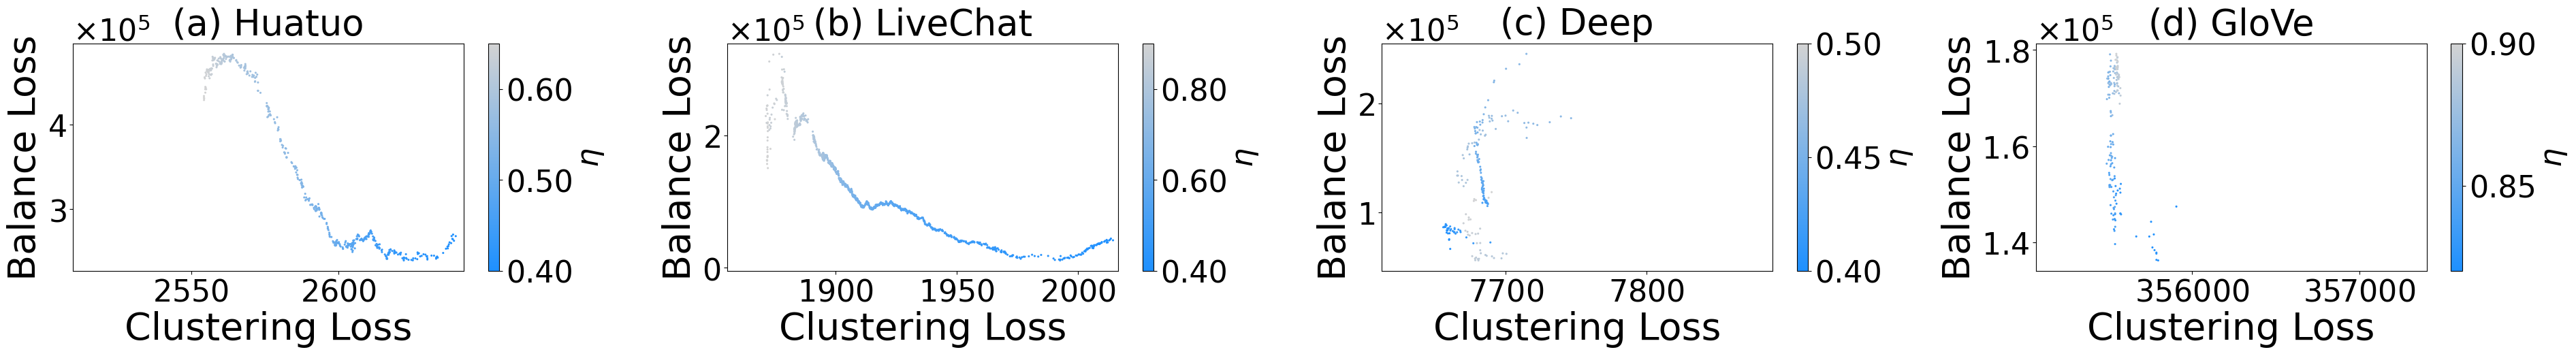

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter
import numpy as np
from scipy.interpolate import UnivariateSpline

file_path = '/content/sample_data/lambda_results.csv'
df = pd.read_csv(file_path)

titles = ["(a) Huatuo", "(b) LiveChat", "(c) Deep", "(d) GloVe"]
# 确保数据按 t 排序
df = df.sort_values(by='Lambda')
datasets = df['Dataset'].unique()

fs = 40
fig, axes = plt.subplots(1, 4, figsize=(40, 6))
axes = axes.flatten()

# 定义渐变颜色映射
# cmap = plt.cm.viridis
# norm = mcolors.Normalize(vmin=0, vmax=1)
cmap = mcolors.LinearSegmentedColormap.from_list("custom_blue_gray", ["dodgerblue", "lightgray"])

datasets = sorted(datasets[:8])

def find_pareto_frontier(sse, balance_loss):
    """筛选帕累托最优点"""
    pareto_points = []
    min_balance_loss = float('inf')  # 当前最小的 balance loss

    # 按 SSE 升序排序
    sorted_points = sorted(zip(sse, balance_loss), key=lambda x: x[0])

    for s, b in sorted_points:
        if b <= min_balance_loss:
            pareto_points.append((s, b))
            min_balance_loss = b

    return np.array(pareto_points)


offset_x = [50, 200, 50, 80, 100, 300, 50, 50]
offset_y = [50, 100, 1500, 20, 80, 300, 200, 20]

vmins = [0.4, 0.4, 0.4, 0.82]
vmaxs = [0.65, 0.9, 0.5, 0.9]

for i, dataset in enumerate(datasets):
    dataset_df = df[df['Dataset'] == dataset]

    # norm = mcolors.Normalize(vmin=dataset_df['Lambda'].min(), vmax=dataset_df['Lambda'].max())

    # Scatter plot with blue-to-gray gradient and smaller markers
    # scatter = axes[i].scatter(dataset_df['SSE'], dataset_df['Balance_Loss'], c=dataset_df['Lambda'], cmap=cmap,
    #                            norm=norm, edgecolor='none', s=5)  # Reduced marker size (s=8)
    vmin = vmins[i]
    vmax = vmaxs[i]
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

    # 只保留区间内数据
    subset_df = dataset_df[(dataset_df['Lambda'] >= vmin) & (dataset_df['Lambda'] <= vmax)]

    scatter = axes[i].scatter(
        subset_df['SSE'],
        subset_df['Balance_Loss'],
        c=subset_df['Lambda'],
        cmap=cmap,
        norm=norm,
        edgecolor='none',
        s=5
    )

    formatter = mticker.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-3, 3))  # 自动确定显示范围
    axes[i].yaxis.set_major_formatter(formatter)
    axes[i].yaxis.offsetText.set_fontsize(fs * 0.8)

    axes[i].set_title(titles[i], fontsize = fs*0.95, pad=10)
    axes[i].set_xlabel('Clustering Loss', fontsize=fs)
    axes[i].set_ylabel('Balance Loss', fontsize=fs)

    # 设置横坐标范围，动态根据数据计算
    axes[i].set_xlim(dataset_df['SSE'].min()*1.1 - dataset_df['SSE'].max()*0.1, dataset_df['SSE'].max()*1.001)  # 适当放大或缩小
    axes[i].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    axes[i].tick_params(axis='both', which='major', labelsize=fs  * 0.8)
    axes[i].xaxis.offsetText.set_fontsize(fs)

    cb = fig.colorbar(scatter, ax=axes[i], format='%.2f')
    cb.set_label(r'$\eta$', fontsize=fs * 0.8)
    cb.ax.tick_params(labelsize=fs * 0.8)


plt.tight_layout()
# plt.subplots_adjust(wspace=0.25)
# plt.subplots_adjust(hspace=0.48)
# plt.savefig('/content/sample_data/sse-balance.pdf', format="pdf", bbox_inches="tight")
# fig.subplots_adjust(wspace=0.35)
# fig.subplots_adjust(hspace=0.3)
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.34)  # 调整左右边距和子图间隔
fig.savefig("sse-balance.pdf", format="pdf", bbox_inches="tight")
plt.show()


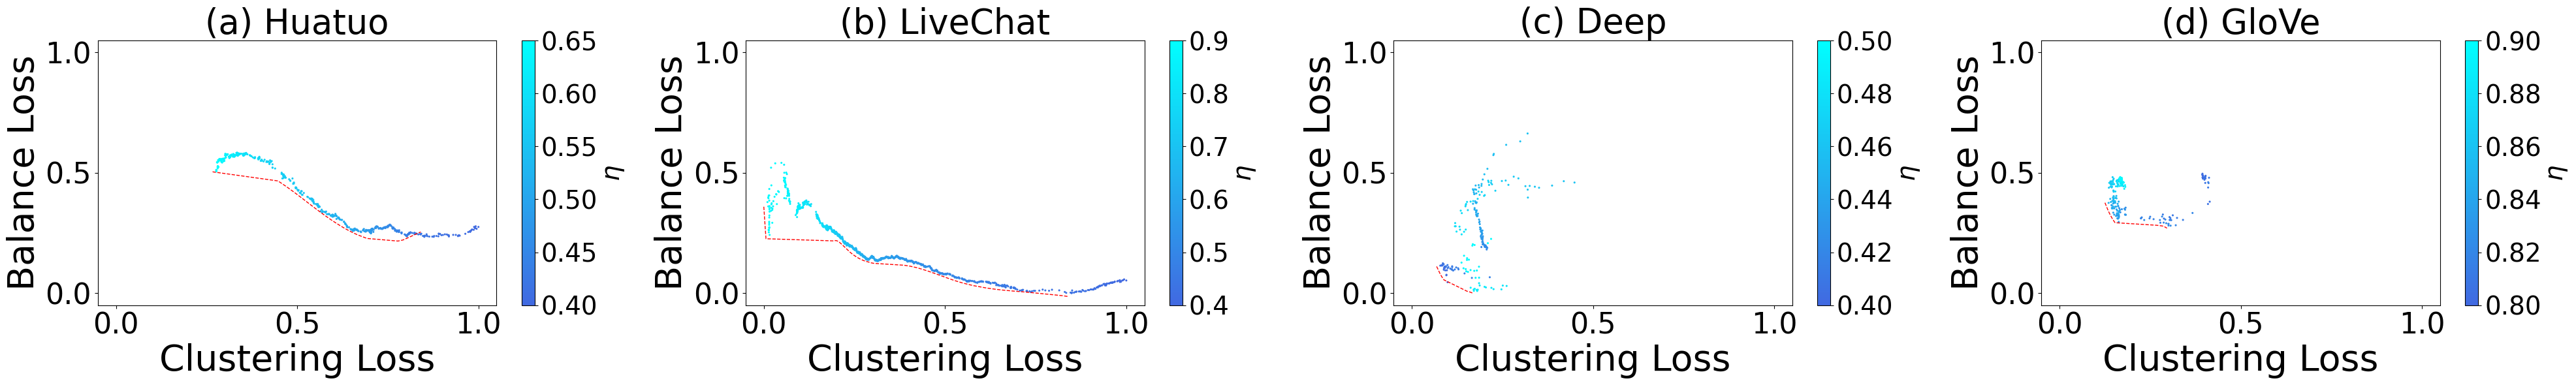

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter
import numpy as np
from scipy.interpolate import UnivariateSpline

file_path = '/content/sample_data/lambda_results.csv'
df = pd.read_csv(file_path)

titles = ["(a) Huatuo", "(b) LiveChat", "(c) Deep", "(d) GloVe"]
# 确保数据按 t 排序
df = df.sort_values(by='Lambda')
datasets = df['Dataset'].unique()

fs = 40
fig, axes = plt.subplots(1, 4, figsize=(40, 6))
axes = axes.flatten()

# 定义渐变颜色映射
# cmap = plt.cm.viridis
# norm = mcolors.Normalize(vmin=0, vmax=1)
cmap = mcolors.LinearSegmentedColormap.from_list("custom_blue_gray", ["royalblue", "cyan"])
#
datasets = sorted(datasets[:8])

# def normalize(data):
#     """归一化数据到 [0, 1] 区间"""
#     return (data - data.min()) / (data.max() - data.min())
def normalize(data, data_min=None, data_max=None):
    """归一化数据到 [0, 1] 区间，可指定全局最小最大值"""
    if data_min is None:
        data_min = data.min()
    if data_max is None:
        data_max = data.max()
    return (data - data_min) / (data_max - data_min)


def find_pareto_frontier(sse, balance_loss):
    """筛选帕累托最优点"""
    pareto_points = []
    min_balance_loss = float('inf')  # 当前最小的 balance loss

    # 按 SSE 升序排序
    sorted_points = sorted(zip(sse, balance_loss), key=lambda x: x[0])

    for s, b in sorted_points:
        if b <= min_balance_loss:
            pareto_points.append((s, b))
            min_balance_loss = b

    return np.array(pareto_points)

vmins = [0.4, 0.4, 0.4, 0.8]
vmaxs = [0.65, 0.9, 0.5, 0.9]

for i, dataset in enumerate(datasets):
    dataset_df = df[df['Dataset'] == dataset]

    # norm = mcolors.Normalize(vmin=dataset_df['Lambda'].min(), vmax=dataset_df['Lambda'].max())

    # # 绘制散点图
    # scatter = axes[i].scatter(normalized_sse, normalized_balance_loss, c=dataset_df['Lambda'], cmap=cmap,
    #                            norm=norm, edgecolor='none', s=8)  # Reduced marker size (s=8)
    vmin = vmins[i]
    vmax = vmaxs[i]
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

    # 只保留区间内数据
    subset_df = dataset_df[(dataset_df['Lambda'] >= vmin) & (dataset_df['Lambda'] <= vmax)]

    # 数据归一化
    # normalized_sse = normalize(subset_df['SSE'])
    # normalized_balance_loss = normalize(subset_df['Balance_Loss'])
    normalized_sse = normalize(
        subset_df['SSE'],
        data_min=dataset_df['SSE'].min(),
        data_max=dataset_df['SSE'].max()
    )

    normalized_balance_loss = normalize(
        subset_df['Balance_Loss'],
        data_min=dataset_df['Balance_Loss'].min(),
        data_max=dataset_df['Balance_Loss'].max()
    )

    scatter = axes[i].scatter(
        normalized_sse,
        normalized_balance_loss,
        c=subset_df['Lambda'],
        cmap=cmap,
        norm=norm,
        edgecolor='none',
        s=5
    )

    # 计算归一化后帕累托最优点
    pareto_points = find_pareto_frontier(normalized_sse, normalized_balance_loss)

    # 使用样条插值绘制平滑曲线
    offset_x = 0.01
    offset_y = 0.01
    shifted_sse = pareto_points[:, 0] - offset_x
    shifted_balance = pareto_points[:, 1] - offset_y
    spline = UnivariateSpline(shifted_sse, shifted_balance, s=0.007)  # s控制平滑程度
    axes[i].plot(shifted_sse, spline(shifted_sse), color = 'red', linewidth=1, linestyle='--', label="Shifted Pareto Front")  # 绘制帕累托前沿曲线
    # spline = UnivariateSpline(pareto_points[:, 0], pareto_points[:, 1], s=0.01)  # s 控制平滑程度
    # axes[i].plot(pareto_points[:, 0], spline(pareto_points[:, 0]), color='red', linewidth=1.5, label="Pareto Front")


    # 设置坐标轴标签和标题
    axes[i].set_title(titles[i], fontsize=fs * 0.95, pad=5)
    axes[i].set_xlabel('Clustering Loss', fontsize=fs)
    axes[i].set_ylabel('Balance Loss', fontsize=fs)

    # 设置坐标轴范围
    axes[i].set_xlim(-0.05, 1.05)  # 归一化后，范围在 [0, 1] 之间
    axes[i].set_ylim(-0.05, 1.05)
    axes[i].tick_params(axis='both', which='major', labelsize=fs * 0.8)

    # 添加颜色条
    cb = fig.colorbar(scatter, ax=axes[i])
    cb.set_label(r'$\eta$', fontsize=fs * 0.7)
    cb.ax.tick_params(labelsize=fs * 0.7)

plt.tight_layout()
fig.subplots_adjust(wspace=0.3)
fig.subplots_adjust(hspace=0.48)
fig.savefig("n-sse-balance.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
# mykmeans上clusting loss和balance loss的负相关
import numpy as np
import time
from scipy.linalg import orth # For creating orthogonal matrices
from pathlib import Path
import pandas as pd
import gc

class MyKMeans:
    def __init__(self, d, k, niter=25, nredo=1, verbose=False,
                    min_points_per_centroid=1, max_points_per_centroid=1e9,
                    seed=1234, gpu=False, spherical=False,
                    update_index=True, frozen_centroids=False,
                    lambda_=1.0):
        # d: dimensionality of data (n_features)
        # k: number of clusters (c in BKNC)
        self.d_features = d
        self.k = k  # c in BKNC
        self.niter = niter # Niter in BKNC
        self.lambda_ = lambda_ # lambda in BKNC
        self.lambda_reformed = (1-lambda_)/lambda_
        self.seed = seed
        self.verbose = verbose

        # Other Faiss Kmeans parameters - not directly used by BKNC logic
        self.nredo = nredo
        self.min_points_per_centroid = min_points_per_centroid
        self.max_points_per_centroid = max_points_per_centroid
        self.gpu = gpu # BKNC as implemented here is CPU-only
        self.spherical = spherical
        self.update_index = update_index
        self.frozen_centroids = frozen_centroids

        # BKNC specific results
        self.F_ = None          # The F matrix from BKNC (n_samples x k)
        self.R_ = None          # The R matrix (k x k)
        self.Y_ = None          # The Y matrix (one-hot labels, n_samples x k)
        self.labels_ = None     # Final cluster assignments (idx, shape: n_samples)
        self.obj_history_ = []  # History of the objective function trace(F'X_m'X_mF)
        self.final_obj_ = None
        self.runtime_ = 0

        # For compatibility with original FCFC structure
        self.centroids = None # Will be populated with cluster means
        self.obj = None # Can store obj_history_ here

        # Final metrics as requested
        self.sse_ = None
        self.balance_loss_ = None


    def _initialize_Y_bknc(self, n_samples, c):
        """
        Equivalent to MATLAB's init function for Y.
        Creates an n_samples x c one-hot encoded matrix from random labels.
        """
        # labels are 0 to c-1
        # This internal seeding should be fine as long as the main train method sets the overall seed.
        # If this method were called multiple times independently *within* one train call,
        # and expected different Ys, then it would need a different seeding strategy.
        # For now, it's called once per train.
        labels = np.random.randint(0, c, size=n_samples)
        Y = np.zeros((n_samples, c), dtype=int)
        Y[np.arange(n_samples), labels] = 1
        return Y

    def _calculate_cluster_centroids(self, data, labels, num_clusters, data_dim):
        """
        Calculates the mean of points in each cluster.
        data: (n_samples, n_features)
        labels: (n_samples,)
        num_clusters: k
        data_dim: d_features
        """
        centroids = np.zeros((num_clusters, data_dim))
        if labels is None: # Should not happen if called after labels are set
             if self.verbose:
                print("Warning: Labels are None in _calculate_cluster_centroids. Returning zero centroids.")
             return centroids

        for i in range(num_clusters):
            cluster_points = data[labels == i]
            if len(cluster_points) > 0:
                centroids[i] = np.mean(cluster_points, axis=0)
            else:
                if self.verbose:
                    print(f"Warning: Cluster {i} is empty during centroid calculation. Assigning a random data point as its centroid.")
                if len(data) > 0:
                    # Use a random number generator seeded by self.seed for consistent fallback
                    rng_fallback = np.random.RandomState(self.seed + i) # Add i for variety if multiple fallbacks
                    centroids[i] = data[rng_fallback.choice(len(data))]
                else: # No data points at all (edge case)
                    centroids[i] = np.zeros(data_dim)
        return centroids

    def train(self, x, weights=None, init_centroids=None):
        """
        Implements the BKNC algorithm.
        x: data matrix (n_samples, n_features)
        weights: Not used by BKNC.
        init_centroids: Not used by BKNC.
        """
        np.random.seed(self.seed) # Set seed for reproducibility for the entire train method
        start_time = time.time()

        if x.shape[1] != self.d_features:
            raise ValueError(f"Input data feature dimension {x.shape[1]} "
                             f"does not match class initialized dimension {self.d_features}")

        X_m = x.T  # (n_features, n_samples) - X_m is the MATLAB-like X
        n_features_internal, n_samples = X_m.shape # n_features_internal is self.d_features
        c = self.k # Number of clusters

        # Initialize Y (n_samples, c)
        # _initialize_Y_bknc uses np.random, which is now seeded by self.seed
        Y = self._initialize_Y_bknc(n_samples, c)

        # Initialize R (c, c) as a random orthogonal matrix
        # np.random.rand is also affected by the global seed set above
        R = orth(np.random.rand(c, c))

        obj_log = np.zeros(self.niter)

        # F_loop initialization is also seeded
        for iter_num in range(self.niter):
            F_loop = orth(np.random.rand(n_samples, c))
            G = Y @ R.T

            for _ in range(10):
                TempM_F = X_m @ F_loop
                M_calc_F = 2 * X_m.T @ TempM_F + self.lambda_reformed * G
                U_f, _, Vh_f = np.linalg.svd(M_calc_F, full_matrices=False)
                F_loop = U_f @ Vh_f
            F_current = F_loop

            N_calc_R = F_current.T @ Y
            U_r, _, Vh_r = np.linalg.svd(N_calc_R, full_matrices=False)
            R = U_r @ Vh_r

            P_calc_Y = R.T @ F_current.T
            idx = np.argmax(P_calc_Y, axis=0)
            Y = np.zeros((n_samples, c), dtype=int)
            Y[np.arange(n_samples), idx] = 1

            TempF_obj = X_m @ F_current
            obj_log[iter_num] = np.trace(TempF_obj.T @ TempF_obj)

            if self.verbose and (iter_num % 5 == 0 or iter_num == self.niter -1):
                print(f"Iter {iter_num+1}/{self.niter}, BKNC Obj: {obj_log[iter_num]:.4f}")

        self.runtime_ = time.time()

        # Store BKNC results
        self.F_ = F_current
        self.R_ = R
        self.Y_ = Y # This is the one-hot version of labels from the last iteration
        self.labels_ = idx # finalInd in MATLAB (0-indexed labels)
        self.obj_history_ = obj_log
        self.final_obj_ = obj_log[-1]
        self.obj = self.obj_history_ # Compatibility

        # --- Calculate final centroids, SSE, and Balance Loss ---
        # self.centroids are calculated based on original data `x` and final `self.labels_`
        self.centroids = self._calculate_cluster_centroids(x, self.labels_, self.k, self.d_features)

        # Calculate SSE
        current_sse = 0
        if self.labels_ is not None and self.centroids is not None:
            for i in range(n_samples):
                cluster_idx = self.labels_[i]
                point = x[i, :]
                centroid_val = self.centroids[cluster_idx, :]
                current_sse += np.sum((point - centroid_val)**2) # Squared Euclidean distance
        self.sse_ = current_sse

        # Calculate Balance Loss
        current_balance_loss = 0
        if self.labels_ is not None:
            cluster_sizes = np.bincount(self.labels_, minlength=self.k)
            ideal_size = n_samples / self.k
            current_balance_loss = np.sum((cluster_sizes - ideal_size)**2)
        self.balance_loss_ = current_balance_loss

        # Final runtime calculation
        self.runtime_ = time.time() - start_time # Corrected runtime calculation

        if self.verbose:
            print(f"BKNC training completed in {self.runtime_:.4f} seconds.")
            print(f"Final BKNC objective (trace): {self.final_obj_:.4f}")
            unique_labels_final, counts_final = np.unique(self.labels_, return_counts=True)
            print(f"Final cluster sizes: {dict(zip(unique_labels_final, counts_final))}")
            if self.centroids is not None:
                print(f"Shape of calculated centroids: {self.centroids.shape}")
            print(f"Final SSE: {self.sse_:.4f}")
            print(f"Final Balance Loss: {self.balance_loss_:.4f}")


# 优化后的数据加载函数
def load_data_chunked(path, dtype='float32', chunksize=1000):
    """分块加载大数据集避免内存溢出"""
    chunks = []
    for chunk in pd.read_csv(path, header=None, chunksize=chunksize):
        chunks.append(chunk.astype(dtype))
    return np.concatenate(chunks, axis=0)

def run_experiment(model_class, dataset_path, dimensions, n_clusters, lambda_, niter):
    """运行实验并返回单次实验的 combined 值"""
    try:
        X_data = load_data_chunked(dataset_path)
        model = model_class(d=dimensions, k=n_clusters, niter=niter, lambda_=lambda_, seed=1234, verbose=False)
        model.train(X_data) if hasattr(model, 'train') else model.fit(X_data)
        sse = model.sse_
        balance_loss = model.balance_loss_
        return sse + balance_loss
    finally:
        if 'X_data' in locals(): del X_data
        if 'model' in locals(): del model
        gc.collect()

if __name__ == '__main__':
    model_class = MyKMeans
    k = 10

    # 选定的 8 个 lambda
    # lambda_values = [0.76, 0.78, 0.80, 0.82, 0.84, 0.86, 0.88, 0.90]
    # iter 从 1 到 50
    # iter_values = list(range(1, 51))
    lambda_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    iter_values = [1, 10, 20, 30, 40, 50]

    # 数据集列表
    datasets = [
        ("/content/sample_data/Huatuo_1024d_10k.csv", 1024),
        ("/content/sample_data/LiveChat_1024d_10k.csv", 1024),
        # ("/content/sample_data/bigann_128d_10k.csv", 128),
        ("/content/sample_data/deep_96d_10k.csv", 96),
        ("/content/sample_data/glove_300d_10k.csv", 300),
        ("/content/sample_data/sift_128d_10k.csv", 128)
    ]

    # 所有结果存到列表
    all_results = []

    for dataset_path, dim in datasets:
        dataset_name = Path(dataset_path).stem

        for lambda_ in lambda_values:
            row = []
            for niter in iter_values:
                print(f"Running {dataset_name}: lambda={lambda_:.2f}, iter={niter}")
                combined = run_experiment(model_class, dataset_path, dim, k, lambda_, niter)
                row.append(combined)
            all_results.append(row)  # 一行是一个 lambda 的 50 个 iter 的 combined

    # 转 DataFrame，列名是 iter=1~50
    columns = [f"iter_{i}" for i in iter_values]
    results_df = pd.DataFrame(all_results, columns=columns)

    # 保存
    output_path = "/content/sample_data/iter_lambda_results.csv"
    results_df.to_csv(output_path, index=False)
    print(f"\nExperiment results saved to '{output_path}'")

Running Huatuo-1024d_10k: lambda=0.75, iter=1
Running Huatuo-1024d_10k: lambda=0.75, iter=10
Running Huatuo-1024d_10k: lambda=0.75, iter=20
Running Huatuo-1024d_10k: lambda=0.75, iter=30
Running Huatuo-1024d_10k: lambda=0.75, iter=40
Running Huatuo-1024d_10k: lambda=0.75, iter=50
Running Huatuo-1024d_10k: lambda=0.80, iter=1
Running Huatuo-1024d_10k: lambda=0.80, iter=10
Running Huatuo-1024d_10k: lambda=0.80, iter=20
Running Huatuo-1024d_10k: lambda=0.80, iter=30
Running Huatuo-1024d_10k: lambda=0.80, iter=40
Running Huatuo-1024d_10k: lambda=0.80, iter=50
Running Huatuo-1024d_10k: lambda=0.85, iter=1
Running Huatuo-1024d_10k: lambda=0.85, iter=10
Running Huatuo-1024d_10k: lambda=0.85, iter=20
Running Huatuo-1024d_10k: lambda=0.85, iter=30
Running Huatuo-1024d_10k: lambda=0.85, iter=40
Running Huatuo-1024d_10k: lambda=0.85, iter=50
Running Huatuo-1024d_10k: lambda=0.90, iter=1
Running Huatuo-1024d_10k: lambda=0.90, iter=10
Running Huatuo-1024d_10k: lambda=0.90, iter=20
Running Huatuo-10

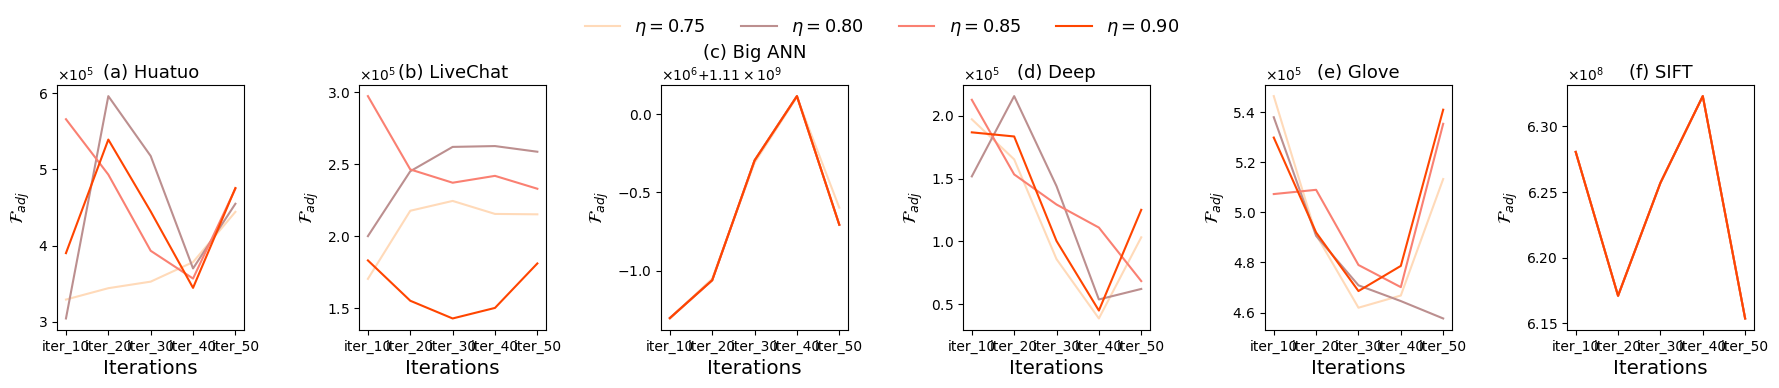

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import rcParams as mpl
import pandas as pd
from scipy.signal import savgol_filter

colors = ['peachpuff','rosybrown', 'salmon', 'orangered', 'sienna', 'sandybrown', 'tan', 'darkorange']
marker = ["o", "x", "v", "s", "*", "*", "x", "x"]
# labels = ["$\eta=0.76$", "$\eta=0.78$","$\eta=0.80$","$\eta=0.82$","$\eta=0.84$","$\eta=0.86$","$\eta=0.88$","$\eta=0.90$"]
labels = ["$\eta=0.75$","$\eta=0.80$","$\eta=0.85$","$\eta=0.90$"]

df = pd.read_csv('/content/sample_data/iter_lambda_results.csv')
# df = df.to_numpy()

fs = 13
fig, axs = plt.subplots(1, 6, figsize=(18, 3.5))  # 改为一行六图
fig.tight_layout()
makesize = 0.01

# def smooth_data(data):
#     window_length = 51
#     polyorder = 3
#     return savgol_filter(data, window_length, polyorder)
def smooth_data(data):
    max_len = len(data)
    window_length = min(51, max_len if max_len % 2 == 1 else max_len - 1)  # 必须是奇数
    polyorder = min(3, window_length - 1)
    return savgol_filter(data, window_length, polyorder)


def drawMapWithLabel(x, y, row_num, start_row, axs):
    for i in range(row_num):
        linestyle = '-'
        axs[y].plot(df.columns[1:],  # X: 从第1列开始是迭代值
                    smooth_data(df.iloc[start_row + i, 1:].astype(float)),
                    linestyle=linestyle,
                    marker=marker[i],
                    markersize=makesize,
                    markerfacecolor='none',
                    markeredgewidth=1,
                    color=colors[i],
                    label=labels[i])


def drawMap(x, y, row_num, start_row, axs):
    for i in range(row_num):
        linestyle = '-'
        axs[y].plot(df.columns[1:],
                    smooth_data(df.iloc[start_row + i, 1:].astype(float)),
                    linestyle=linestyle,
                    marker=marker[i],
                    markersize=makesize,
                    markerfacecolor='none',
                    markeredgewidth=1,
                    color=colors[i])


# row_num = 8
row_num = 4
total_rows = df.shape[0]
num_plots = total_rows // row_num  # 应该是 6

for idx in range(num_plots):
    start_row = idx * row_num
    if idx == 0:
        drawMapWithLabel(0, idx, row_num, start_row, axs)
    else:
        drawMap(0, idx, row_num, start_row, axs)


fig.legend(loc='upper center', fontsize=fs*0.98, bbox_to_anchor=(0.5, 1.12),
           ncol=8, fancybox=False, shadow=False, frameon=False)

titles = ["(a) Huatuo", "(b) LiveChat", "(c) Big ANN", "(d) Deep", "(e) Glove", "(f) SIFT"]
for i, ax in enumerate(axs):
    formatter = mticker.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-3, 3))
    ax.yaxis.set_major_formatter(formatter)
    ax.set_title(titles[i], fontsize=fs, pad=5)
    ax.set_ylabel('$\mathcal{F}_{adj}$', fontsize=fs)
    ax.set_xlabel("Iterations", fontsize=fs*1.1)

fig.tight_layout()
fig.subplots_adjust(hspace=0.4, top=0.88)
mpl.update({'font.size': 13})
fig.savefig("eta_selection.pdf", format="pdf", bbox_inches="tight")
plt.show()